In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, cohen_kappa_score
from PIL import Image
import random

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)


# Function to color grayscale images
def color_grayscale_arr(arr, color):
    """Converts grayscale image to red or blue."""
    assert arr.ndim == 2
    dtype = arr.dtype
    h, w = arr.shape
    arr = np.reshape(arr, [h, w, 1])
    if color == 'red':
        arr = np.concatenate([arr, np.zeros((h, w, 2), dtype=dtype)], axis=2)
    elif color == 'blue':
        arr = np.concatenate([np.zeros((h, w, 1), dtype=dtype), arr, np.zeros((h, w, 1), dtype=dtype)], axis=2)
    return arr

# Custom dataset for Colored MNIST
class ColoredMNIST(datasets.VisionDataset):
    def __init__(self, root='./data', env='train_red', transform=None, target_transform=None):
        super(ColoredMNIST, self).__init__(root, transform=transform, target_transform=target_transform)
        self.prepare_colored_mnist()
        if env in ['train_red', 'train_blue', 'test_red', 'test_blue']:
            self.data_label_tuples = torch.load(os.path.join(self.root, 'ColoredMNIST', env) + '.pt')
        else:
            raise RuntimeError(f'{env} env unknown. Valid envs are train_red, train_blue, test_red, test_blue')

    def __getitem__(self, index):
        img, target = self.data_label_tuples[index]
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return img, target

    def __len__(self):
        return len(self.data_label_tuples)

    def prepare_colored_mnist(self):
        colored_mnist_dir = os.path.join(self.root, 'ColoredMNIST')
        if os.path.exists(os.path.join(colored_mnist_dir, 'train_red.pt')) \
                and os.path.exists(os.path.join(colored_mnist_dir, 'train_blue.pt')) \
                and os.path.exists(os.path.join(colored_mnist_dir, 'test_red.pt')) \
                and os.path.exists(os.path.join(colored_mnist_dir, 'test_blue.pt')):
            print('Colored MNIST dataset already exists')
            return
    
        print('Preparing Colored MNIST')
        train_mnist = datasets.MNIST(self.root, train=True, download=True)
        test_mnist = datasets.MNIST(self.root, train=False, download=True)
        train_red_set = []
        train_blue_set = []
        test_red_set = []
        test_blue_set = []
        for idx, (im, label) in enumerate(train_mnist):
            if idx % 10000 == 0:
                print(f'Converting image {idx}/{len(train_mnist)}')
            im_array = np.array(im)
    
            # Assign color based on index for red and blue
            if idx < 30000:
                color_red = True
                color_blue = False
            else:
                color_red = False
                color_blue = True
    
            colored_arr = color_grayscale_arr(im_array, 'red' if color_red else 'blue')
            if color_red:
                train_red_set.append((Image.fromarray(colored_arr), label))
            elif color_blue:
                train_blue_set.append((Image.fromarray(colored_arr), label))
    
        for idx, (im, label) in enumerate(test_mnist):
            im_array = np.array(im)
            if idx % 2 == 0:
                colored_arr = color_grayscale_arr(im_array, 'red')
                test_red_set.append((Image.fromarray(colored_arr), label))
            else:
                colored_arr = color_grayscale_arr(im_array, 'blue')
                test_blue_set.append((Image.fromarray(colored_arr), label))
    
        os.makedirs(colored_mnist_dir, exist_ok=True)
        torch.save(train_red_set, os.path.join(colored_mnist_dir, 'train_red.pt'))
        torch.save(train_blue_set, os.path.join(colored_mnist_dir, 'train_blue.pt'))
        torch.save(test_red_set, os.path.join(colored_mnist_dir, 'test_red.pt'))
        torch.save(test_blue_set, os.path.join(colored_mnist_dir, 'test_blue.pt'))



# Load and transform the datasets
transform = transforms.Compose([transforms.ToTensor()])

from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(size=(32, 32), scale=(0.8, 1.0)),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


# Load the full training sets
train_dataset_red = ColoredMNIST(root='./data', env='train_red', transform=transform)
train_dataset_blue = ColoredMNIST(root='./data', env='train_blue', transform=transform)

# Split the datasets into training and validation sets
train_size_red = int(0.8 * len(train_dataset_red))
val_size_red = len(train_dataset_red) - train_size_red
train_dataset_red_split, val_dataset_red = random_split(train_dataset_red, [train_size_red, val_size_red])

train_size_blue = int(0.8 * len(train_dataset_blue))
val_size_blue = len(train_dataset_blue) - train_size_blue
train_dataset_blue_split, val_dataset_blue = random_split(train_dataset_blue, [train_size_blue, val_size_blue])

# Create data loaders
train_A_loader = DataLoader(train_dataset_red_split, batch_size=64, shuffle=True)
val_A_loader = DataLoader(val_dataset_red, batch_size=64, shuffle=False)

train_B_loader = DataLoader(train_dataset_blue_split, batch_size=64, shuffle=True)
val_B_loader = DataLoader(val_dataset_blue, batch_size=64, shuffle=False)

test_A_loader = DataLoader(
    ColoredMNIST(root='./data', env='test_red', transform=transform),
    batch_size=64, shuffle=False)
test_B_loader = DataLoader(
    ColoredMNIST(root='./data', env='test_blue', transform=transform),
    batch_size=64, shuffle=False)

Colored MNIST dataset already exists


C:\Users\gslax\AppData\Local\Temp\ipykernel_11724\3689486103.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data_label_tuples = torch.load(os.path.join(self.root,

Colored MNIST dataset already exists
Colored MNIST dataset already exists
Colored MNIST dataset already exists


In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, cohen_kappa_score
from PIL import Image
import random

In [3]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, random_split

class BinarySplitMNIST(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = (targets % 2).long()  # Map even -> 0, odd -> 1

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

# Download and preprocess MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to PyTorch tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

mnist_train = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

# Create datasets with binary labels
train_data = BinarySplitMNIST(mnist_train.data, mnist_train.targets)
test_data = BinarySplitMNIST(mnist_test.data, mnist_test.targets)


def split_by_label(dataset, label):
    indices = [i for i, target in enumerate(dataset.targets) if target == label]
    data = dataset.data[indices]
    targets = dataset.targets[indices]
    return BinarySplitMNIST(data, targets)

# Split into even and odd domains
even_train_data = split_by_label(train_data, 0)  # Even digits (label 0)
odd_train_data = split_by_label(train_data, 1)   # Odd digits (label 1)

even_test_data = split_by_label(test_data, 0)    # Even digits (label 0)
odd_test_data = split_by_label(test_data, 1)     # Odd digits (label 1)


# Split train data into train and validation sets
train_even, val_even = random_split(even_train_data, [int(len(even_train_data)*0.8), len(even_train_data) - int(len(even_train_data)*0.8)])
train_odd, val_odd = random_split(odd_train_data, [int(len(odd_train_data)*0.8), len(odd_train_data) - int(len(odd_train_data)*0.8)])

# Create DataLoaders
batch_size = 64

# Even domain DataLoaders
train_A_loader = DataLoader(train_even, batch_size=batch_size, shuffle=True)
val_A_loader = DataLoader(val_even, batch_size=batch_size, shuffle=False)
test_A_loader = DataLoader(even_test_data, batch_size=batch_size, shuffle=False)

# Odd domain DataLoaders
train_B_loader = DataLoader(train_odd, batch_size=batch_size, shuffle=True)
val_B_loader = DataLoader(val_odd, batch_size=batch_size, shuffle=False)
test_B_loader = DataLoader(odd_test_data, batch_size=batch_size, shuffle=False)


In [4]:
from scipy.stats import entropy

def compute_kl_divergence(loader1, loader2, num_classes):
    def get_class_distribution(loader, num_classes):
        class_counts = torch.zeros(num_classes)
        for _, targets in loader:
            class_counts += torch.bincount(targets, minlength=num_classes)
        return class_counts / class_counts.sum()  # Normalize to probabilities

    P = get_class_distribution(loader1, num_classes).numpy()
    Q = get_class_distribution(loader2, num_classes).numpy()

    return entropy(P, Q)  # KL divergence

from torch.nn.functional import cosine_similarity

def compute_cosine_similarity(loader1, loader2, model, device):
    def get_average_embedding(loader, model, device):
        model.eval()
        embeddings = []
        with torch.no_grad():
            for inputs, _ in loader:
                inputs = inputs.to(device)
                features = model(inputs)  # Extract features
                embeddings.append(features.mean(dim=0))
        return torch.stack(embeddings).mean(dim=0)

    embedding1 = get_average_embedding(loader1, model, device)
    embedding2 = get_average_embedding(loader2, model, device)

    return cosine_similarity(embedding1, embedding2, dim=0).item()


In [5]:
# Example model for feature extraction
class FeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Flatten()  # Flatten as a simple extractor

    def forward(self, x):
        return self.fc(x)

model = FeatureExtractor().to("cuda")

In [6]:
# Function to compute Cohen's Kappa
def compute_kappa(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data, target in loader:
            output = model(data)
            preds = torch.argmax(output, axis=1)
            all_preds.extend(preds.numpy())
            all_labels.extend(target.numpy())
    kappa = cohen_kappa_score(all_labels, all_preds)
    return kappa

In [7]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(50 * 20 * 20, 500)  # Adjusted the input size for fc1
        self.fc2 = nn.Linear(500, 10)  # 10 classes for digit classification

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1, 50 * 20 * 20)  # Adjusted the view to match the new tensor size
        x = F.relu(self.fc1(x))
        logits = self.fc2(x)
        return logits

In [8]:
import torch.nn as nn
import torch.nn.functional as F

class BinaryMNISTClassifier(nn.Module):
    def __init__(self, input_dim=28*28, hidden_dim=128, output_dim=1):
        super(BinaryMNISTClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        #self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        x = F.leaky_relu(self.bn1(self.fc1(x)))
        #x = self.dropout(x)
        #x = F.leaky_relu(self.bn2(self.fc2(x)))
        #x = self.dropout(x)
        x = torch.sigmoid(self.fc3(x))  # Sigmoid activation for binary output
        return x


In [9]:
# Training and Evaluation Functions
def train(model, loader, optimizer, criterion, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for data, target in loader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(loader)}')

In [10]:
def train_with_patience(model, loader, optimizer, criterion, epochs=10, patience=5):
    model.train()
    best_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0

        for data, target in loader:
            data, target = data.float(), target.float()  # Ensure data is float for model compatibility
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target.view(-1, 1))  # Reshape target for BCELoss
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            # Calculate accuracy
            predictions = (output > 0.5).int()  # Threshold at 0.5
            correct += (predictions.view(-1) == target).sum().item()
            total += target.size(0)

        avg_loss = total_loss / len(loader)
        accuracy = correct / total
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

        # Early stopping mechanism
        if avg_loss < best_loss:
            best_loss = avg_loss
            epochs_no_improve = 0
            # Save the best model (optional)
            best_model_state = model.state_dict()
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f'Early stopping triggered after {epoch + 1} epochs.')
            break

    # Load the best model state (optional)
    model.load_state_dict(best_model_state)


In [11]:
import torch
import torch.nn.functional as F

class EWC:
    def __init__(self, model, dataloader, importance=10000):
        self.model = model
        self.dataloader = dataloader
        self.importance = importance
        # Store initial parameters as a reference
        self.initial_params = {n: p.clone() for n, p in self.model.named_parameters()}
        # Compute Fisher diagonal using online update
        self.fisher_diagonal = self.compute_fisher_information()

    def compute_fisher_information(self):
        fisher_diagonal = {n: torch.zeros_like(p) for n, p in self.model.named_parameters()}
        self.model.eval()
        
        for i, (data, target) in enumerate(self.dataloader, 1):
            data, target = data.float(), target.long()
            self.model.zero_grad()
            output = self.model(data)
            # Use negative log likelihood loss
            loss = F.nll_loss(F.log_softmax(output, dim=1), target)
            loss.backward()
            
            # Online update of the Fisher diagonal
            for n, p in self.model.named_parameters():
                if p.grad is not None:
                    grad_squared = p.grad ** 2
                    fisher_diagonal[n] = fisher_diagonal[n] + (grad_squared - fisher_diagonal[n]) / i

        return fisher_diagonal

    def penalty(self):
        penalty = 0
        for n, p in self.model.named_parameters():
            penalty += (self.fisher_diagonal[n] * (p - self.initial_params[n]) ** 2).sum()
        return self.importance * penalty


In [12]:
# Synaptic Intelligence
class SynapticIntelligence:
    def __init__(self, model, dataloader, importance=1000):
        self.model = model
        self.dataloader = dataloader
        self.importance = importance
        self.omega = {n: torch.zeros_like(p) for n, p in self.model.named_parameters()}
        self.initial_params = {n: p.clone() for n, p in self.model.named_parameters()}
        self.update_omega()

    def update_omega(self):
        self.model.eval()
        for data, target in self.dataloader:
            data, target = data.float(), target.long()
            self.model.zero_grad()
            output = self.model(data)
            loss = F.nll_loss(F.log_softmax(output, dim=1), target)
            loss.backward()
            for n, p in self.model.named_parameters():
                if p.grad is not None:
                    self.omega[n] += p.grad.abs() / len(self.dataloader)

    def penalty(self):
        penalty = 0
        for n, p in self.model.named_parameters():
            penalty += (self.omega[n] * (p - self.initial_params[n]) ** 2).sum()
        return self.importance * penalty

def train_with_si(model, loader, optimizer, criterion, si, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        total_penalty = 0
        for data, target in loader:
            data, target = data.float(), target.float().view(-1, 1)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            penalty = si.penalty()
            total_loss += loss.item()
            total_penalty += penalty.item()
            loss += penalty
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(loader)}, Penalty: {total_penalty / len(loader)}')

In [13]:
def train_with_ewc(model, optimizer, dataloaders, ewc=None, lambda_ewc=0.1, epochs=5):
    """
    Train the model with or without EWC penalty for binary classification.
    
    Args:
        model: Neural network model to train.
        optimizer: Optimizer for training.
        dataloaders: Dictionary containing 'train' and optionally 'val' dataloaders.
        ewc: Instance of the EWC class, or None if not using EWC.
        lambda_ewc: Importance of the EWC penalty (default is 0.1).
        epochs: Number of epochs to train.
    """
    criterion = nn.BCEWithLogitsLoss()  # For binary classification with logits

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        total_penalty = 0.0

        for inputs, targets in dataloaders['train']:
            # Ensure inputs and targets have correct types
            inputs = inputs.float()  # Convert to torch.float for the model
            targets = targets.float().view(-1, 1)  # Convert to torch.float and reshape to (batch_size, 1)

            optimizer.zero_grad()
            outputs = model(inputs)

            # Calculate binary cross-entropy loss
            loss = criterion(outputs, targets)

            # Add EWC penalty if applicable
            if ewc is not None:
                ewc_penalty = ewc.penalty(model)
                loss += lambda_ewc * ewc_penalty
                total_penalty += ewc_penalty.item()

            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_loss = running_loss / len(dataloaders['train'])
        avg_penalty = total_penalty / len(dataloaders['train'])
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}, Penalty: {avg_penalty:.4f}")

In [14]:
# Data Rehearsal
def train_with_rehearsal(model, loader, rehearsal_loader, optimizer, criterion, epochs=10, replay_ratio=0.5):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for (data, target), (rehearsal_data, rehearsal_target) in zip(loader, rehearsal_loader):
            data = data.float()
            target = target.float().view(-1, 1) 
            rehearsal_data = rehearsal_data.float()
            rehearsal_target = rehearsal_target.float().view(-1, 1) 
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            if np.random.rand() < replay_ratio:
                rehearsal_output = model(rehearsal_data)
                rehearsal_loss = criterion(rehearsal_output, rehearsal_target)
                loss += rehearsal_loss
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(loader)}')


In [15]:
class RehearsalBuffer:
    def __init__(self, buffer_size=500):
        self.buffer_size = buffer_size
        self.buffer = []

    def add_to_buffer(self, data, target):
        for i in range(len(data)):
            if len(self.buffer) >= self.buffer_size:
                self.buffer.pop(0)
            self.buffer.append((data[i], target[i]))

    def get_buffer(self):
        data, target = zip(*self.buffer)
        return torch.stack(data), torch.tensor(target)


In [16]:
def train_with_buffer(model, loader, buffer, optimizer, criterion, epochs=20):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for data, target in loader:
            data = data.float()
            target = target.float().view(-1, 1) 
            buffer.add_to_buffer(data, target)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            if len(buffer.buffer) > 0:
                buffer_data, buffer_target = buffer.get_buffer()
                buffer_data = data.float()
                buffer_target = target.float().view(-1, 1) 
                buffer_output = model(buffer_data)
                loss += criterion(buffer_output, buffer_target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(loader):.4f}')


In [17]:
epoch_stats_other = {
    "si": {"acc_B": [], "loss_B": [], "domain_A_during_B":[],"domain_A_during_B_loss":[],"val_domain_A_during_B":[],"val_acc_B":[],"B_during_A":[],"A_during_A":[],"B_during_A_val":[],"A_during_A_val":[]},
    "pnn": {"acc_B": [], "loss_B": [], "domain_A_during_B":[],"domain_A_during_B_loss":[],"val_domain_A_during_B":[],"val_acc_B":[],"B_during_A":[],"A_during_A":[],"B_during_A_val":[],"A_during_A_val":[]},
    "reh": {"acc_B": [], "loss_B": [], "domain_A_during_B":[],"domain_A_during_B_loss":[],"val_domain_A_during_B":[],"val_acc_B":[],"B_during_A":[],"A_during_A":[],"B_during_A_val":[],"A_during_A_val":[]}
}

num_runs = 10
epochs = 25

In [15]:
epoch_stats_other

NameError: name 'epoch_stats_other' is not defined

In [32]:
def train_with_si(model, optimizer, dataloaders, si=None, lambda_si=0.1, epochs=5):
    criterion = nn.BCEWithLogitsLoss()

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        total_penalty = 0.0

        for inputs, targets in dataloaders['train']:
            inputs = inputs.float()
            targets = targets.float().view(-1, 1)

            optimizer.zero_grad()
            outputs = model(inputs)

            # Task loss
            task_loss = criterion(outputs, targets)

            # SI penalty with log scaling
            if si is not None:
                si_penalty = si.penalty(model)

                # Logarithmic scaling of the penalty
                log_scaled_penalty = torch.log(1 + si_penalty + 1e-6)  # Add small constant for numerical stability
                task_loss += lambda_si * log_scaled_penalty
                total_penalty += log_scaled_penalty.item()

            # Backward and optimize
            task_loss.backward()
            optimizer.step()
            running_loss += task_loss.item()

        # Log losses
        avg_loss = running_loss / len(dataloaders['train'])
        avg_penalty = total_penalty / len(dataloaders['train'])
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Log-Scaled Penalty: {avg_penalty:.4f}")


In [33]:
class SynapticIntelligence:
    def __init__(self, model, dataloader):
        """
        Synaptic Intelligence (SI) implementation.
        Args:
            model: Neural network model.
            dataloader: DataLoader for the current task.
        """
        self.model = model
        self.dataloader = dataloader
        self.omega = {}
        self.optimal_params = {}

        # Initialize omega and optimal_params
        self._initialize_params()

    def _initialize_params(self):
        """
        Initialize or reset omega and optimal_params to match the current model's parameters.
        """
        self.omega = {n: torch.zeros_like(p) for n, p in self.model.named_parameters() if p.requires_grad}
        self.optimal_params = {n: p.clone().detach() for n, p in self.model.named_parameters() if p.requires_grad}

    def update_omega(self):
        """
        Update omega values based on gradients of BCEWithLogitsLoss for BinaryMNIST.
        """
        self.model.eval()
        fisher_diagonal = {n: torch.zeros_like(p) for n, p in self.model.named_parameters() if p.requires_grad}
        
        dataset_size = len(self.dataloader.dataset)  # Normalize by dataset size
        for data, target in self.dataloader:
            self.model.zero_grad()

            # Ensure correct data types
            data = data.float()
            target = target.float().view(-1, 1)  # Reshape targets for BCEWithLogitsLoss

            output = self.model(data)
            loss = F.binary_cross_entropy_with_logits(output, target)  # BCEWithLogitsLoss
            loss.backward()

            # Accumulate squared gradients
            for n, p in self.model.named_parameters():
                if p.grad is not None and p.requires_grad:
                    fisher_diagonal[n] += (p.grad ** 2)

        # Normalize and update Omega
        for n in fisher_diagonal:
            if n in self.omega:
                self.omega[n] += fisher_diagonal[n] / dataset_size  # Normalize
            else:
                self.omega[n] = fisher_diagonal[n] / dataset_size

    def store_optimal_params(self):
        """
        Store the current model parameters as the optimal parameters after training a task.
        """
        self.optimal_params = {n: p.clone().detach() for n, p in self.model.named_parameters() if p.requires_grad}

    def penalty(self, model):
        """
        Calculate the SI penalty based on the omega values and changes in parameters.
        """
        penalty = 0.0
        for n, p in model.named_parameters():
            if n in self.omega and n in self.optimal_params:
                diff = p - self.optimal_params[n]
                term = (self.omega[n] * diff ** 2).sum()
                penalty += term
        return penalty


In [ ]:
num_runs = 10
epochs = 100
learning_rate = 0.0000005
criterion = torch.nn.BCEWithLogitsLoss()
for run in range(num_runs):
    print(f"Run {run + 1}/{num_runs}")

    # Synaptic Intelligence (SI)
    model_si = BinaryMNISTClassifier()
    optimizer = optim.Adam(model_si.parameters(), lr=learning_rate)
    
    task_A_during_A_run = []
    task_B_during_A_run = []

    task_A_during_A_run_val = []
    task_B_during_A_run_val = []
    si = SynapticIntelligence(model_si,train_A_loader)
    
    # Train on Red domain
    for epoch in range(epochs):
        train_with_si(model_si, optimizer, {'train': train_A_loader, 'val': val_A_loader}, si=None, lambda_si=0, epochs=1)

        # Evaluate on test set for Domain B
        accuracy_taskA_during_A, _, _, _ = evaluate(model_si, test_A_loader , criterion)
        task_A_during_A_run.append(accuracy_taskA_during_A)

        # Evaluate on test set for Domain B
        accuracy_taskB_during_A, _, _, _ = evaluate(model_si, test_B_loader , criterion)
        task_B_during_A_run.append(accuracy_taskB_during_A)

        # Evaluate on test set for Domain B
        accuracy_taskA_during_A_val, _, _, _ = evaluate(model_si, val_A_loader , criterion)
        task_A_during_A_run_val.append(accuracy_taskA_during_A_val)

        # Evaluate on test set for Domain B
        accuracy_taskB_during_A_val, _, _, _ = evaluate(model_si, val_B_loader , criterion)
        task_B_during_A_run_val.append(accuracy_taskB_during_A_val)

    epoch_stats_other["si"]["A_during_A"].append(task_A_during_A_run)
    epoch_stats_other["si"]["B_during_A"].append(task_B_during_A_run)

    epoch_stats_other["si"]["A_during_A_val"].append(task_A_during_A_run_val)
    epoch_stats_other["si"]["B_during_A_val"].append(task_B_during_A_run_val)
    
    # Evaluate initial performance on Red domain
    metrics_red_initial_si = evaluate(model_si, test_A_loader,criterion)
    print(f"Red Domain - Initial with SI: {metrics_red_initial_si}")

    # Evaluate initial performance on Red domain - validation
    metrics_red_initial_si_val = evaluate(model_si, val_A_loader,criterion)
    print(f"Red Domain - Initial with SI - validation: {metrics_red_initial_si_val}")

    task_A_during_B_si_run = []
    task_B_si_run = []
    val_A_during_B_si_run = []
    val_B_si_run = []

    si.update_omega()
    si.store_optimal_params() 
    
    # Train on Blue domain with SI
    for epoch in range(200):
        train_with_si(model_si, optimizer, {'train': train_B_loader, 'val': val_B_loader}, si=si, lambda_si=96000, epochs=1)

        # Evaluate on test set for Domain B
        accuracy_taskB_during_si, _, _, _ = evaluate(model_si, test_B_loader , criterion)
        task_B_si_run.append(accuracy_taskB_during_si)

        # Evaluate on validation set for Domain B
        accuracy_taskB_during_si_val, _, _, _ = evaluate(model_si, val_B_loader, criterion)
        val_B_si_run.append(accuracy_taskB_during_si_val)
        print("Domain B Performance During Domain B ",accuracy_taskB_during_si_val)

        # Evaluate performance on Domain A during training on Domain B (test and validation)
        accuracy_A_during_taskB_during_si, _, _, _ = evaluate(model_si, test_A_loader, criterion)
        task_A_during_B_si_run.append(accuracy_A_during_taskB_during_si)

        accuracy_A_during_taskB_during_si_val, _, _, _ = evaluate(model_si, val_A_loader, criterion)
        val_A_during_B_si_run.append(accuracy_A_during_taskB_during_si_val)
        print("Domain A Performance During Domain B ",accuracy_A_during_taskB_during_si_val)

    epoch_stats_other["si"]["domain_A_during_B"].append(task_A_during_B_si_run)
    epoch_stats_other["si"]["acc_B"].append(task_B_si_run)

    # Store validation metrics for each run
    epoch_stats_other["si"]["val_domain_A_during_B"].append(val_A_during_B_si_run)
    epoch_stats_other["si"]["val_acc_B"].append(val_B_si_run)
    
    # Evaluate performance on Blue domain with SI
    metrics_blue_si = evaluate(model_si, test_B_loader,criterion)
    print(f"Blue Domain with SI: {metrics_blue_si}")

    # Evaluate performance on Blue domain with SI - Validation
    metrics_blue_si_val = evaluate(model_si, val_B_loader,criterion)
    print(f"Blue Domain with SI - validation: {metrics_blue_si_val}")
    
    # Evaluate performance on Red domain after training on Blue domain with SI
    metrics_red_after_blue_si = evaluate(model_si, test_A_loader,criterion)
    print(f"Red Domain after Blue with SI: {metrics_red_after_blue_si}")

    # Evaluate performance on Red domain after training on Blue domain with SI - validation
    metrics_red_after_blue_si_val = evaluate(model_si, val_A_loader,criterion)
    print(f"Red Domain after Blue with SI - validation: {metrics_red_after_blue_si_val}")

    with open('epoch_stats_other_dil_bench_split_mnist_no_dropout.json', 'w') as f:
        json.dump(epoch_stats_other, f, indent=4)





In [ ]:
epochs = 100
num_runs = 10
for run in range(num_runs):
    print(f"Run {run + 1}/{num_runs}")

    # Data Rehearsal
    model_rehearsal = BinaryMNISTClassifier()
    optimizer = optim.Adam(model_rehearsal.parameters(), lr=learning_rate)
    buffer = RehearsalBuffer(buffer_size=1500)
    task_A_during_A_run = []
    task_B_during_A_run = []

    task_A_during_A_run_val = []
    task_B_during_A_run_val = []
    
    # Train on Red domain
    #train(model_rehearsal, train_A_loader, optimizer_rehearsal, criterion, epochs=50)
    for epoch in range (epochs):
        train_with_patience(model_rehearsal, train_A_loader, optimizer, criterion, epochs=1,patience=50)
        #train_with_buffer(model_rehearsal, train_A_loader, buffer,optimizer, criterion, epochs=1)

        # Evaluate on test set for Domain B
        accuracy_taskA_during_A, _, _, _ = evaluate(model_rehearsal, test_A_loader , criterion)
        task_A_during_A_run.append(accuracy_taskA_during_A)

        # Evaluate on test set for Domain B
        accuracy_taskB_during_A, _, _, _ = evaluate(model_rehearsal, test_B_loader , criterion)
        task_B_during_A_run.append(accuracy_taskB_during_A)

        # Evaluate on test set for Domain B
        accuracy_taskA_during_A_val, _, _, _ = evaluate(model_rehearsal, val_A_loader , criterion)
        task_A_during_A_run_val.append(accuracy_taskA_during_A_val)

        # Evaluate on test set for Domain B
        accuracy_taskB_during_A_val, _, _, _ = evaluate(model_rehearsal, val_B_loader , criterion)
        task_B_during_A_run_val.append(accuracy_taskB_during_A_val)

    epoch_stats_other["reh"]["A_during_A"].append(task_A_during_A_run)
    epoch_stats_other["reh"]["B_during_A"].append(task_B_during_A_run)

    epoch_stats_other["reh"]["A_during_A_val"].append(task_A_during_A_run_val)
    epoch_stats_other["reh"]["B_during_A_val"].append(task_B_during_A_run_val)
    
    # Evaluate initial performance on Red domain
    metrics_red_initial_rehearsal = evaluate(model_rehearsal, test_A_loader,criterion)
    print(f"Red Domain - Initial with Rehearsal: {metrics_red_initial_rehearsal}")

    # Evaluate initial performance on Red domain - validation
    metrics_red_initial_reh_val = evaluate(model_rehearsal, val_A_loader,criterion)
    print(f"Red Domain - Initial with rehearsal - validation: {metrics_red_initial_reh_val}")

    task_A_during_B_reh_run = []
    task_B_reh_run = []
    val_A_during_B_reh_run = []
    val_B_reh_run = []
    
    # Train on Blue domain with rehearsal
    for epoch in range(200):
        train_with_rehearsal(model_rehearsal, train_B_loader, train_A_loader, optimizer, criterion, epochs=1, replay_ratio=0.45)
        #train_with_buffer(model_rehearsal, train_B_loader, buffer,optimizer, criterion, epochs=1)

        # Evaluate on test set for Domain B
        accuracy_taskB_during_reh, _, _, _ = evaluate(model_rehearsal, test_B_loader , criterion)
        task_B_reh_run.append(accuracy_taskB_during_reh)

        # Evaluate on validation set for Domain B
        accuracy_taskB_during_reh_val, _, _, _ = evaluate(model_rehearsal, val_B_loader, criterion)
        val_B_reh_run.append(accuracy_taskB_during_reh_val)
        print("B during B ",accuracy_taskB_during_reh_val)
        
        # Evaluate performance on Domain A during training on Domain B (test and validation)
        accuracy_A_during_taskB_during_reh, _, _, _ = evaluate(model_rehearsal, test_A_loader, criterion)
        task_A_during_B_reh_run.append(accuracy_A_during_taskB_during_reh)

        accuracy_A_during_taskB_during_reh_val, _, _, _ = evaluate(model_rehearsal, val_A_loader, criterion)
        val_A_during_B_reh_run.append(accuracy_A_during_taskB_during_reh_val)
        print("A during B ",accuracy_A_during_taskB_during_reh_val)

    epoch_stats_other["reh"]["domain_A_during_B"].append(task_A_during_B_reh_run)
    epoch_stats_other["reh"]["acc_B"].append(task_B_reh_run)

    # Store validation metrics for each run
    epoch_stats_other["reh"]["val_domain_A_during_B"].append(val_A_during_B_reh_run)
    epoch_stats_other["reh"]["val_acc_B"].append(val_B_reh_run)

    
    # Evaluate performance on Blue domain with rehearsal
    metrics_blue_rehearsal = evaluate(model_rehearsal, test_B_loader,criterion)
    print(f"Blue Domain with Rehearsal: {metrics_blue_rehearsal}")

    # Evaluate performance on Blue domain with rehearsal - validation
    metrics_blue_rehearsal_val = evaluate(model_rehearsal, val_A_loader,criterion)
    print(f"Blue Domain with Rehearsal - validation: {metrics_blue_rehearsal_val}")
    
    # Evaluate performance on Red domain after training on Blue domain with rehearsal
    metrics_red_after_blue_rehearsal = evaluate(model_rehearsal, test_A_loader,criterion)
    print(f"Red Domain after Blue with Rehearsal: {metrics_red_after_blue_rehearsal}")

    # Evaluate performance on Red domain after training on Blue domain with rehearsal - validation
    metrics_red_after_blue_rehearsal_val = evaluate(model_rehearsal, val_B_loader,criterion)
    print(f"Red Domain after Blue with Rehearsal - validation: {metrics_red_after_blue_rehearsal_val}")

    # with open('epoch_stats_other_dil_bench_split_mnist_no_dropout.json', 'w') as f:
    #     json.dump(epoch_stats_other, f, indent=4)

In [273]:
# Combining the two dictionaries
epoch_stats_other_reh_buffer_2000 = {}

for key in epoch_stats_other.keys():
    epoch_stats_other_reh_buffer_2000[key] = {}
    for sub_key in epoch_stats_other[key]:
        # Combine lists for each sub-key
        epoch_stats_other_reh_buffer_2000[key][sub_key] = epoch_stats_other[key][sub_key]
         



In [296]:
# Combining the two dictionaries
epoch_stats_other_reh_buffer_1500 = {}

for key in epoch_stats_other.keys():
    epoch_stats_other_reh_buffer_1500[key] = {}
    for sub_key in epoch_stats_other[key]:
        # Combine lists for each sub-key
        epoch_stats_other_reh_buffer_1500[key][sub_key] = epoch_stats_other[key][sub_key]
         



In [38]:
def train_with_ewc_with_patience(model, loader, ewc, optimizer, criterion, epochs=10, patience=50):
    model.train()
    best_loss = float('inf')
    epochs_no_improve = 0
    epoch_loss = []
    epoch_accuracy = []

    for epoch in range(epochs):
        total_loss = 0
        total_penalty = 0
        correct = 0
        total = 0

        for data, target in loader:
            # Ensure data and target are the correct types
            data = data.float()  # Convert inputs to torch.float
            target = target.long()  # Convert targets to torch.long (for classification)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            penalty = ewc.penalty()
            total_loss += loss.item()
            total_penalty += penalty.item()
            loss += penalty
            loss.backward()
            optimizer.step()

            # Compute accuracy
            predicted = output.argmax(dim=1, keepdim=True)  # Assuming multi-class classification
            correct += predicted.eq(target.view_as(predicted)).sum().item()
            total += target.size(0)

        avg_loss = total_loss / len(loader)
        accuracy = correct / total

        epoch_loss.append(avg_loss)
        epoch_accuracy.append(accuracy)

        print(f'Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}, Penalty: {total_penalty:.4f}, Accuracy: {accuracy:.4f}')

        if avg_loss < best_loss:
            best_loss = avg_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f'Early stopping triggered after {epoch + 1} epochs.')
            break

    return epoch_accuracy, epoch_loss


In [23]:
def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    all_predictions = []
    all_targets = []
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.float(), y.float()  # Ensure consistent data types
            output = model(x)
            loss = criterion(output, y.view(-1, 1))  # Reshape target for BCELoss
            total_loss += loss.item()

            # Threshold the output at 0.5 to obtain binary predictions
            predictions = (output > 0.5).int()
            all_predictions.extend(predictions.numpy().flatten())
            all_targets.extend(y.numpy().flatten())

    # Compute evaluation metrics
    accuracy = accuracy_score(all_targets, all_predictions)
    precision = precision_score(all_targets, all_predictions, average='binary', zero_division=0)
    recall = recall_score(all_targets, all_predictions, average='binary', zero_division=0)
    kappa = cohen_kappa_score(all_targets, all_predictions)

    return accuracy, precision, recall, kappa


In [40]:
class OnlineEWC:
    def __init__(self, model, dataloader):
        """
        Online EWC implementation for binary classification.
        Args:
            model: Neural network model.
            dataloader: DataLoader for the current task.
        """
        self.model = model
        self.dataloader = dataloader
        self.fisher_matrix = {}
        self.optimal_params = {}

    def update_fisher_matrix(self):
        """
        Update the Fisher matrix using the online method for binary classification.
        """
        self.model.eval()
        fisher_diagonal = {n: torch.zeros_like(p) for n, p in self.model.named_parameters() if p.requires_grad}
    
        for i, (data, target) in enumerate(self.dataloader, 1):
            # Ensure input data and target have the correct types
            data = data.float()  # Convert inputs to torch.float
            target = target.float().view(-1, 1)  # Convert targets to torch.float and reshape to (batch_size, 1)
    
            self.model.zero_grad()
            output = self.model(data)
    
            # Calculate loss using BCEWithLogitsLoss
            loss = F.binary_cross_entropy_with_logits(output, target)
            loss.backward()
    
            # Update Fisher diagonal iteratively
            for n, p in self.model.named_parameters():
                if p.grad is not None:
                    fisher_diagonal[n] += (p.grad ** 2 - fisher_diagonal[n]) / i
    
        # Update Fisher matrix with the new Fisher diagonal values
        for n in fisher_diagonal:
            if n in self.fisher_matrix:
                self.fisher_matrix[n] += fisher_diagonal[n]
            else:
                self.fisher_matrix[n] = fisher_diagonal[n]

    def store_optimal_params(self):
        """
        Store a copy of the model's current parameters as the optimal parameters for the current task.
        """
        self.optimal_params = {n: p.clone().detach() for n, p in self.model.named_parameters() if p.requires_grad}

    def penalty(self, model):
        """
        Calculate the EWC penalty based on the Fisher matrix and optimal parameters.
        """
        penalty = 0.0
        for n, p in model.named_parameters():
            if p.requires_grad and n in self.fisher_matrix:
                penalty += (self.fisher_matrix[n] * (p - self.optimal_params[n]) ** 2).sum()
        return penalty


In [41]:
import torch
import torch.nn as nn
import torch.optim as optim

def train_with_ewc(model, optimizer, dataloaders, ewc=None, lambda_ewc=0.1, epochs=5):
    """
    Train the model with or without EWC penalty for binary classification.
    
    Args:
        model: Neural network model to train.
        optimizer: Optimizer for training.
        dataloaders: Dictionary containing 'train' and optionally 'val' dataloaders.
        ewc: Instance of the EWC class, or None if not using EWC.
        lambda_ewc: Importance of the EWC penalty (default is 0.1).
        epochs: Number of epochs to train.
    """
    criterion = nn.BCEWithLogitsLoss()  # For binary classification with logits

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        total_penalty = 0.0

        for inputs, targets in dataloaders['train']:
            # Ensure inputs and targets have correct types
            inputs = inputs.float()  # Convert to torch.float for the model
            targets = targets.float().view(-1, 1)  # Convert to torch.float and reshape to (batch_size, 1)

            optimizer.zero_grad()
            outputs = model(inputs)

            # Calculate binary cross-entropy loss
            loss = criterion(outputs, targets)

            # Add EWC penalty if applicable
            if ewc is not None:
                ewc_penalty = ewc.penalty(model)
                loss += lambda_ewc * ewc_penalty
                total_penalty += ewc_penalty.item()

            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_loss = running_loss / len(dataloaders['train'])
        avg_penalty = total_penalty / len(dataloaders['train'])
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}, Penalty: {avg_penalty:.4f}")


In [ ]:
# Initialize storage for results, including "Untrained_A"
results = {
    "untrained_A": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "initial_A": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "B_ewc": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "A_after_B_ewc": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "B_no_ewc": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "A_after_B_no_ewc": {"accuracy": [], "precision": [], "recall": [], "kappa": []}
}

results_val = {
    "initial_A": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "B_ewc": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "A_after_B_ewc": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "B_no_ewc": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "A_after_B_no_ewc": {"accuracy": [], "precision": [], "recall": [], "kappa": []}
}

# Store per-epoch values for plotting
epoch_stats = {
    "Initial": {"accuracy": [], "loss": []},
    "ewc": {"accuracy": [], "loss": [], "task_A_during_B":[], "val_task_A_during_B": [], "val_acc": [], "val_loss": [],"val_task_B":[],"task_B":[],"B_during_A":[],"A_during_A":[],"B_during_A_val":[],"A_during_A_val":[]},
    "no_ewc": {"accuracy": [], "loss": [], "task_A_during_B": [], "val_task_A_during_B": [], "val_acc": [], "val_loss": [],"task_B":[],"val_task_B":[],"B_during_A":[],"A_during_A":[],"B_during_A_val":[],"A_during_A_val":[]}
}
dom_a_weights = []
import json
epochs = 100
num_runs = 10
learning_rate = 0.0000005
for run in range(num_runs):
    print(f"Run {run + 1}/{num_runs}")

    # Initialize model, optimizer, and criterion
    model = BinaryMNISTClassifier()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.BCELoss()
    criterion = torch.nn.BCEWithLogitsLoss()
    ewc = OnlineEWC(model, train_A_loader)

    
    # Evaluate "Untrained_A" - performance on Task A before any training
    accuracy_untrained_A, precision_untrained_A, recall_untrained_A, kappa_untrained_A = evaluate(model, train_A_loader, criterion)
    print(f"Task A - Untrained: Accuracy: {accuracy_untrained_A}, Precision: {precision_untrained_A}, Recall: {recall_untrained_A}, Kappa: {kappa_untrained_A}")
    results["untrained_A"]["accuracy"].append(accuracy_untrained_A)
    results["untrained_A"]["precision"].append(precision_untrained_A)
    results["untrained_A"]["recall"].append(recall_untrained_A)
    results["untrained_A"]["kappa"].append(kappa_untrained_A)

    task_B_during_A_run = []
    task_A_during_A_run = []

    task_B_during_A_run_val = []
    task_A_during_A_run_val = []
    
    # Train and evaluate on Red domain
    print("Training on Red domain")
    for epoch in range(epochs):
        #train_with_patience(model, train_A_loader, optimizer, criterion, epochs=1,patience=50)
        train_with_ewc(model, optimizer, {'train': train_A_loader, 'val': val_A_loader}, ewc=None, lambda_ewc=0, epochs=1)

        # Track performance on Task B
        accuracy_taskB_duringA, _, _, _ = evaluate(model, test_B_loader, criterion)
        print(f"Epoch {epoch + 1} - Task B performance during Task A (with EWC): {accuracy_taskB_duringA:.4f}")
        task_B_during_A_run.append(accuracy_taskB_duringA)

        # Track performance on Task B
        accuracy_taskB_duringA_val, _, _, _ = evaluate(model, val_B_loader, criterion)
        print(f"Epoch {epoch + 1} - Task B performance during Task A (with EWC): {accuracy_taskB_duringA_val:.4f}")
        task_B_during_A_run_val.append(accuracy_taskB_duringA_val)

        # Track performance on Task B
        accuracy_taska_duringA, _, _, _ = evaluate(model, test_A_loader, criterion)
        print(f"Epoch {epoch + 1} - Task A performance during Task A (with EWC): {accuracy_taska_duringA:.4f}")
        task_A_during_A_run.append(accuracy_taska_duringA)

        # Track performance on Task B
        accuracy_taska_duringA_val, _, _, _ = evaluate(model, val_A_loader, criterion)
        print(f"Epoch {epoch + 1} - Task A performance during Task A (with EWC): {accuracy_taska_duringA_val:.4f}")
        task_A_during_A_run_val.append(accuracy_taska_duringA_val)

    epoch_stats["ewc"]["A_during_A"].append(task_A_during_A_run)
    epoch_stats["ewc"]["A_during_A_val"].append(task_A_during_A_run_val)
    epoch_stats["ewc"]["B_during_A"].append(task_B_during_A_run)
    epoch_stats["ewc"]["B_during_A_val"].append(task_B_during_A_run_val)

    ewc.update_fisher_matrix()
    ewc.store_optimal_params()
    
    # Save weights
    torch.save(model.state_dict(), 'initial_domain_dil_bench.pth')
    # Save model weights after Task A training
    dom_a_weights.append(model.state_dict())
    
    print("Evaluating on Red domain")
    # Evaluate initial performance on Task A
    accuracy_taskA_initial, precision_taskA_initial, recall_taskA_initial, kappa_taskA_initial = evaluate(model, test_A_loader, criterion)
    print(f"Task A - Initial: Accuracy: {accuracy_taskA_initial:.4f}, Precision: {precision_taskA_initial:.4f}, Recall: {recall_taskA_initial:.4f}, Cohen's Kappa: {kappa_taskA_initial:.4f}")
    results["initial_A"]["accuracy"].append(accuracy_taskA_initial)
    results["initial_A"]["precision"].append(precision_taskA_initial)
    results["initial_A"]["recall"].append(recall_taskA_initial)
    results["initial_A"]["kappa"].append(kappa_taskA_initial)

    print("Evaluating on Red domain - validation")
    accuracy_taskA_initial_val, precision_taskA_initial_val, recall_taskA_initial_val, kappa_taskA_initial_val = evaluate(model, val_A_loader, criterion)
    print(f"Task A - Initial: Accuracy: {accuracy_taskA_initial_val:.4f}, Precision: {precision_taskA_initial_val:.4f}, Recall: {recall_taskA_initial_val:.4f}, Cohen's Kappa: {kappa_taskA_initial_val:.4f}")
    results_val["initial_A"]["accuracy"].append(accuracy_taskA_initial_val)
    results_val["initial_A"]["precision"].append(precision_taskA_initial_val)
    results_val["initial_A"]["recall"].append(recall_taskA_initial_val)
    results_val["initial_A"]["kappa"].append(kappa_taskA_initial_val)

    # Store task_A_during_B as a list for this run
    task_A_during_B_ewc_run = []
    task_A_during_B_no_ewc_run = []

    task_B_ewc_run = []
    task_B_no_ewc_run = []

    val_task_B_ewc_run = []
    val_task_B_no_ewc_run = []

    val_task_A_during_B_ewc_run = []
    val_task_A_during_B_no_ewc_run = []
    

    for epoch in range(200):
    
        # Train and evaluate on Blue domain with EWC
        print("Training on Blue domain with EWC")
        #train_with_ewc_with_patience(model, train_B_loader, ewc, optimizer, criterion, epochs=1,patience=50)
        train_with_ewc(model, optimizer, {'train': train_B_loader, 'val': val_B_loader}, ewc=ewc, lambda_ewc=1500, epochs=1)
        
        # Track performance on Task B
        accuracy_taskB, _, _, _ = evaluate(model, test_B_loader, criterion)
        print(f"Epoch {epoch + 1} - Task B performance during Task B (with EWC): {accuracy_taskB:.4f}")
        task_B_ewc_run.append(accuracy_taskB)

        # Track performance on Task B
        val_accuracy_taskB, _, _, _ = evaluate(model, val_B_loader, criterion)
        print(f"Epoch {epoch + 1} - Task B performance during Task B - validation set (with EWC): {val_accuracy_taskB:.4f}")
        val_task_B_ewc_run.append(val_accuracy_taskB)
    
        # Track performance on Task A while training on Task B
        accuracy_taskA_during_B_ewc, _, _, _ = evaluate(model, test_A_loader, criterion)
        print(f"Epoch {epoch + 1} - Task A performance during Task B (with EWC): {accuracy_taskA_during_B_ewc:.4f}")
        task_A_during_B_ewc_run.append(accuracy_taskA_during_B_ewc)

        # Track performance on Task A while training on Task B
        val_accuracy_taskA_during_B_ewc, _, _, _ = evaluate(model, val_A_loader, criterion)
        print(f"Epoch {epoch + 1} - Task A performance during Task B - validation set (with EWC): {val_accuracy_taskA_during_B_ewc:.4f}")
        val_task_A_during_B_ewc_run.append(val_accuracy_taskA_during_B_ewc)
        
    epoch_stats["ewc"]["task_A_during_B"].append(task_A_during_B_ewc_run)
    epoch_stats["ewc"]["val_task_A_during_B"].append(val_task_A_during_B_ewc_run)
    epoch_stats["ewc"]["task_B"].append(task_B_ewc_run)
    epoch_stats["ewc"]["val_task_B"].append(val_task_B_ewc_run)
    
    print("Evaluating on Blue domain")
    # Evaluate performance on Electronics with EWC
    accuracy_taskB_ewc, precision_taskB_ewc, recall_taskB_ewc, kappa_taskB_ewc = evaluate(model, test_B_loader, criterion)
    print(f"Task B with EWC: Accuracy: {accuracy_taskB_ewc:.4f}, Precision: {precision_taskB_ewc:.4f}, Recall: {recall_taskB_ewc:.4f}, Cohen's Kappa: {kappa_taskB_ewc:.4f}")
    results["B_ewc"]["accuracy"].append(accuracy_taskB_ewc)
    results["B_ewc"]["precision"].append(precision_taskB_ewc)
    results["B_ewc"]["recall"].append(recall_taskB_ewc)
    results["B_ewc"]["kappa"].append(kappa_taskB_ewc)

    
    # Evaluate on Task B - Validation
    accuracy_taskB_ewc_val, precision_taskB_ewc_val, recall_taskB_ewc_val, kappa_taskB_ewc_val = evaluate(model, val_B_loader, criterion)
    print(f"Task A after Task B with EWC: Accuracy: {accuracy_taskB_ewc_val:.4f}, Precision: {precision_taskB_ewc_val:.4f}, Recall: {recall_taskB_ewc_val:.4f}, Kappa: {kappa_taskB_ewc_val:.4f}")
    results_val["B_ewc"]["accuracy"].append(accuracy_taskB_ewc_val)
    results_val["B_ewc"]["precision"].append(precision_taskB_ewc_val)
    results_val["B_ewc"]["recall"].append(recall_taskB_ewc_val)
    results_val["B_ewc"]["kappa"].append(kappa_taskB_ewc_val)

    
    # Evaluate on Red domain again
    print("Evaluating on Red domain after training on Electronics with EWC")
    # Evaluate performance on Task A after training on Task B with EWC
    accuracy_taskA_after_B_ewc, precision_taskA_after_B_ewc, recall_taskA_after_B_ewc, kappa_taskA_after_B_ewc = evaluate(model, test_A_loader, criterion)
    print(f"Task A after Task B with EWC: Accuracy: {accuracy_taskA_after_B_ewc:.4f}, Precision: {precision_taskA_after_B_ewc:.4f}, Recall: {recall_taskA_after_B_ewc:.4f}, Cohen's Kappa: {kappa_taskA_after_B_ewc:.4f}")
    results["A_after_B_ewc"]["accuracy"].append(accuracy_taskA_after_B_ewc)
    results["A_after_B_ewc"]["precision"].append(precision_taskA_after_B_ewc)
    results["A_after_B_ewc"]["recall"].append(recall_taskA_after_B_ewc)
    results["A_after_B_ewc"]["kappa"].append(kappa_taskA_after_B_ewc)

    # Evaluate performance on Task A after training on Task B with EWC - Validation
    accuracy_taskA_after_B_ewc_val, precision_taskA_after_B_ewc_val, recall_taskA_after_B_ewc_val, kappa_taskA_after_B_ewc_val = evaluate(model, val_A_loader, criterion)
    print(f"Task A after Task B with EWC: Accuracy: {accuracy_taskA_after_B_ewc_val:.4f}, Precision: {precision_taskA_after_B_ewc_val:.4f}, Recall: {recall_taskA_after_B_ewc_val:.4f}, Cohen's Kappa: {kappa_taskA_after_B_ewc_val:.4f}")
    results_val["A_after_B_ewc"]["accuracy"].append(accuracy_taskA_after_B_ewc_val)
    results_val["A_after_B_ewc"]["precision"].append(precision_taskA_after_B_ewc_val)
    results_val["A_after_B_ewc"]["recall"].append(recall_taskA_after_B_ewc_val)
    results_val["A_after_B_ewc"]["kappa"].append(kappa_taskA_after_B_ewc_val)

    #NO EWC
    
    print("Load Red domain Model Weights")
    model2 = BinaryMNISTClassifier()
    model2.load_state_dict(torch.load('initial_domain_dil_bench.pth'))
    optimizer_taskB = optim.Adam(model2.parameters(), lr=learning_rate)
    
    for epoch in range(200):
        # Train and evaluate on Blue domain without EWC
        print("Training on Blue domain without EWC")
        train_with_ewc(model2, optimizer_taskB, {'train': train_B_loader, 'val': val_B_loader}, ewc=None, lambda_ewc=0, epochs=1)

        # Track performance on Task B
        accuracy_taskB_no_ewc, _, _, _ = evaluate(model2, test_B_loader, criterion)
        print(f"Epoch {epoch + 1} - Task B performance during Task B (without EWC): {accuracy_taskB_no_ewc:.4f}")
        task_B_no_ewc_run.append(accuracy_taskB_no_ewc)

        # Track performance on Task B
        val_accuracy_taskB_no_ewc, _, _, _ = evaluate(model2, val_B_loader, criterion)
        print(f"Epoch {epoch + 1} - Task B performance during Task B - validation set (without EWC): {val_accuracy_taskB_no_ewc:.4f}")
        val_task_B_no_ewc_run.append(val_accuracy_taskB_no_ewc)
    
        # Track performance on Task A while training on Task B
        accuracy_taskA_during_B_no_ewc, _, _, _ = evaluate(model2, test_A_loader, criterion)
        print(f"Epoch {epoch + 1} - Task A performance during Task B (without EWC): {accuracy_taskA_during_B_no_ewc:.4f}")
        task_A_during_B_no_ewc_run.append(accuracy_taskA_during_B_no_ewc)

        # Track performance on Task A while training on Task B
        val_accuracy_taskA_during_B_no_ewc, _, _, _ = evaluate(model2, val_A_loader, criterion)
        print(f"Epoch {epoch + 1} - Task A performance during Task B - validation set (without EWC): {val_accuracy_taskA_during_B_no_ewc:.4f}")
        val_task_A_during_B_no_ewc_run.append(val_accuracy_taskA_during_B_no_ewc)
        
    epoch_stats["no_ewc"]["task_A_during_B"].append(task_A_during_B_no_ewc_run)
    epoch_stats["no_ewc"]["val_task_A_during_B"].append(val_task_A_during_B_no_ewc_run)
    epoch_stats["no_ewc"]["task_B"].append(task_B_no_ewc_run)
    epoch_stats["no_ewc"]["val_task_B"].append(val_task_B_no_ewc_run)
        
    
    print("Evaluating on Blue domain")
    # Evaluate performance on Task B without EWC
    accuracy_taskB_no_ewc, precision_taskB_no_ewc, recall_taskB_no_ewc, kappa_taskB_no_ewc = evaluate(model2, test_B_loader, criterion)
    print(f"Task B without EWC: Accuracy: {accuracy_taskB_no_ewc:.4f}, Precision: {precision_taskB_no_ewc:.4f}, Recall: {recall_taskB_no_ewc:.4f}, Cohen's Kappa: {kappa_taskB_no_ewc:.4f}")
    results["B_no_ewc"]["accuracy"].append(accuracy_taskB_no_ewc)
    results["B_no_ewc"]["precision"].append(precision_taskB_no_ewc)
    results["B_no_ewc"]["recall"].append(recall_taskB_no_ewc)
    results["B_no_ewc"]["kappa"].append(kappa_taskB_no_ewc)

    # Evaluate on Task B - validation
    accuracy_taskB_no_ewc_val, precision_taskB_no_ewc_val, recall_taskB_no_ewc_val, kappa_taskB_no_ewc_val = evaluate(model2, val_B_loader, criterion)
    print(f"Task A after Task B without EWC: Accuracy: {accuracy_taskB_no_ewc_val:.4f}, Precision: {precision_taskB_no_ewc_val:.4f}, Recall: {recall_taskB_no_ewc_val:.4f}, Kappa: {kappa_taskB_no_ewc_val:.4f}")
    results_val["B_no_ewc"]["accuracy"].append(accuracy_taskB_no_ewc_val)
    results_val["B_no_ewc"]["precision"].append(precision_taskB_no_ewc_val)
    results_val["B_no_ewc"]["recall"].append(recall_taskB_no_ewc_val)
    results_val["B_no_ewc"]["kappa"].append(kappa_taskB_no_ewc_val)
    
    # Evaluate on Red domain again
    print("Evaluating on Red domain after training on Electronics with EWC")
    
    # Evaluate performance on Task A after training on Task B without EWC
    accuracy_taskA_after_B_no_ewc, precision_taskA_after_B_no_ewc, recall_taskA_after_B_no_ewc, kappa_taskA_after_B_no_ewc = evaluate(model2, test_A_loader, criterion)
    print(f"Task A after Task B without EWC: Accuracy: {accuracy_taskA_after_B_no_ewc:.4f}, Precision: {precision_taskA_after_B_no_ewc:.4f}, Recall: {recall_taskA_after_B_no_ewc:.4f}, Cohen's Kappa: {kappa_taskA_after_B_no_ewc:.4f}")
    results["A_after_B_no_ewc"]["accuracy"].append(accuracy_taskA_after_B_no_ewc)
    results["A_after_B_no_ewc"]["precision"].append(precision_taskA_after_B_no_ewc)
    results["A_after_B_no_ewc"]["recall"].append(recall_taskA_after_B_no_ewc)
    results["A_after_B_no_ewc"]["kappa"].append(kappa_taskA_after_B_no_ewc)

    # Evaluate performance on Task A after training on Task B without EWC - validation
    accuracy_taskA_after_B_no_ewc_val, precision_taskA_after_B_no_ewc_val, recall_taskA_after_B_no_ewc_val, kappa_taskA_after_B_no_ewc_val = evaluate(model2, val_A_loader, criterion)
    print(f"Task A after Task B without EWC: Accuracy: {accuracy_taskA_after_B_no_ewc_val:.4f}, Precision: {precision_taskA_after_B_no_ewc_val:.4f}, Recall: {recall_taskA_after_B_no_ewc_val:.4f}, Cohen's Kappa: {kappa_taskA_after_B_no_ewc_val:.4f}")
    results_val["A_after_B_no_ewc"]["accuracy"].append(accuracy_taskA_after_B_no_ewc_val)
    results_val["A_after_B_no_ewc"]["precision"].append(precision_taskA_after_B_no_ewc_val)
    results_val["A_after_B_no_ewc"]["recall"].append(recall_taskA_after_B_no_ewc_val)
    results_val["A_after_B_no_ewc"]["kappa"].append(kappa_taskA_after_B_no_ewc_val)

    #torch.save(dom_a_weights, 'dom_a_weights_dil_bench.pth')
    # Save model weights after Task A training

    with open('epoch_stats_dil_bench_split_mnist_no_dropout.json', 'w') as f:
        json.dump(epoch_stats, f, indent=4)
    
# Calculate statistics: mean, variance, min, and max
statistics_results = {
    key: {
        metric: {
            "mean": np.mean(values),
            "variance": np.var(values),
            "min": np.min(values),
            "max": np.max(values)
        }
        for metric, values in metrics.items()
    }
    for key, metrics in results.items()
}

# Print results with statistics
print("\nResults with Statistics:")
for key, metrics in statistics_results.items():
    print(f"{key}:")
    for metric, stats in metrics.items():
        print(f"  {metric} - Mean: {stats['mean']:.4f}, Variance: {stats['variance']:.4f}, Min: {stats['min']:.4f}, Max: {stats['max']:.4f}")


In [ ]:
# Printing results in a table format
results = [
    ["Metric", "Red (No EWC)", "Blue (No EWC)", "Red after Blue (No EWC)", "Initial Red (EWC)", "Blue (EWC)", "Red after Blue (EWC)"],
    ["Accuracy", accuracy_red_initial_no_ewc, accuracy_blue_no_ewc, accuracy_red_after_blue_no_ewc, accuracy_red_initial, accuracy_blue_ewc, accuracy_red_after_blue_ewc],
    ["Precision", precision_red_initial_no_ewc, precision_blue_no_ewc, precision_red_after_blue_no_ewc, precision_red_initial, precision_blue_ewc, precision_red_after_blue_ewc],
    ["Recall", recall_red_initial_no_ewc, recall_blue_no_ewc, recall_red_after_blue_no_ewc, recall_red_initial, recall_blue_ewc, recall_red_after_blue_ewc],
    ["F1", f1_red_initial_no_ewc, f1_blue_no_ewc, f1_red_after_blue_no_ewc, f1_red_initial, f1_blue_ewc, f1_red_after_blue_ewc],
    ["Cohen's Kappa", kappa_red_initial_no_ewc, kappa_blue_no_ewc, kappa_red_after_blue_no_ewc, kappa_red_initial, kappa_blue_ewc, kappa_red_after_blue_ewc],
    ["ROC AUC", roc_auc_red_initial_no_ewc, roc_auc_blue_no_ewc, roc_auc_red_after_blue_no_ewc, roc_auc_red_initial, roc_auc_blue_ewc, roc_auc_red_after_blue_ewc]
]

for row in results:
    formatted_row = []
    for item in row:
        if isinstance(item, float):
            formatted_row.append(f"{item:.4f}")
        else:
            formatted_row.append(item)
    print("{:<15} {:<20} {:<20} {:<26} {:<20} {:<20} {:<20}".format(*formatted_row))

In [138]:
import json
# Initialize storage for results, including "Untrained_A"


# Store per-epoch values for plotting
epoch_stats_A = {
    "Initial": {"accuracy": [], "loss": []}
}

epoch_stats_pnn_A = {
    "Initial": {"accuracy": [], "loss": []}
}

epoch_stats_B = {
    "Initial": {"accuracy": [], "loss": []}
}

num_runs = 1
epochs = 50

for run in range(num_runs):
    print(f"Run {run + 1}/{num_runs}")
    model = ConvNet()
    optimizer = optim.Adam(model.parameters(), lr=0.00001)
    criterion = nn.CrossEntropyLoss()

    # Store task_A_during_B as a list for this run
    task_A_run = []
    task_B_run = []
    task_B_run_pnn = []


    for epoch in range(epochs):

        # Train and evaluate on Blue domain with EWC
        print("Training on Blue domain with EWC")
        ewc = EWC
        acc_A_ewc, loss_a_ewc = train_with_patience(model, train_A_loader, optimizer, criterion, epochs=1,patience=50)

        # Track performance on Task A
        accuracy_taskA, _, _, _ = evaluate(model, test_A_loader, criterion)
        print(f"Epoch {epoch + 1} - Task A (with EWC): {accuracy_taskA:.4f}")
        task_A_run.append(accuracy_taskA)

        # Track performance on Task B
        accuracy_taskB, _, _, _ = evaluate(model, test_B_loader, criterion)
        print(f"Epoch {epoch + 1} - Task A (with EWC): {accuracy_taskB:.4f}")
        task_B_run.append(accuracy_taskB)
       
    epoch_stats_A["Initial"]["accuracy"].append(task_A_run)
    epoch_stats_B["Initial"]["accuracy"].append(task_B_run)
    #with open('epoch_stats_B_dil_bench.json', 'w') as f:
      #json.dump(epoch_stats_B, f, indent=4)
    

Run 1/1
Training on Blue domain with EWC
Epoch 1/1, Loss: 0.9673, Accuracy: 0.5923
Epoch 1 - Task A (with EWC): 0.6479
Epoch 1 - Task A (with EWC): 0.5749
Training on Blue domain with EWC
Epoch 1/1, Loss: 0.6387, Accuracy: 0.6550
Epoch 2 - Task A (with EWC): 0.6710
Epoch 2 - Task A (with EWC): 0.6103
Training on Blue domain with EWC
Epoch 1/1, Loss: 0.6289, Accuracy: 0.6683
Epoch 3 - Task A (with EWC): 0.6788
Epoch 3 - Task A (with EWC): 0.6211
Training on Blue domain with EWC
Epoch 1/1, Loss: 0.6220, Accuracy: 0.6777
Epoch 4 - Task A (with EWC): 0.6803
Epoch 4 - Task A (with EWC): 0.6265
Training on Blue domain with EWC
Epoch 1/1, Loss: 0.6184, Accuracy: 0.6816
Epoch 5 - Task A (with EWC): 0.6872
Epoch 5 - Task A (with EWC): 0.6097
Training on Blue domain with EWC
Epoch 1/1, Loss: 0.6142, Accuracy: 0.6888
Epoch 6 - Task A (with EWC): 0.6815
Epoch 6 - Task A (with EWC): 0.5890
Training on Blue domain with EWC
Epoch 1/1, Loss: 0.6102, Accuracy: 0.6929
Epoch 7 - Task A (with EWC): 0.6983

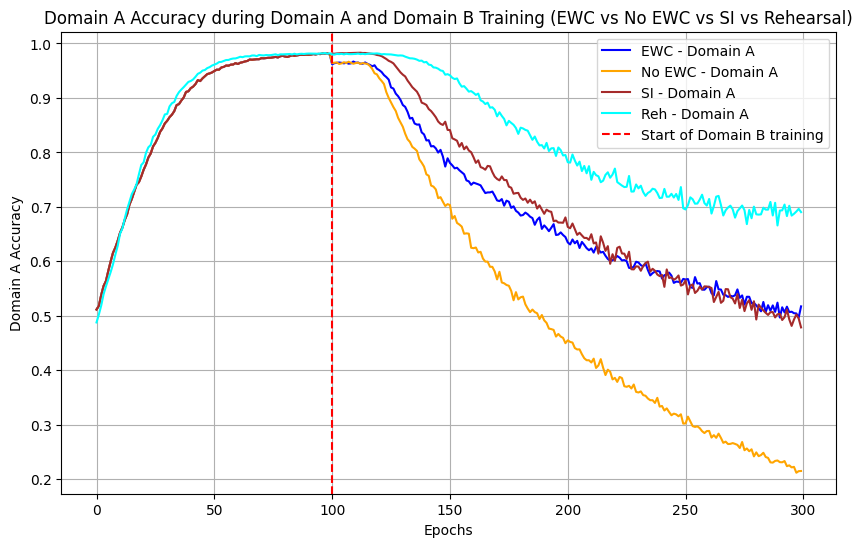

In [60]:
import matplotlib.pyplot as plt
import numpy as np
# Calculate the mean for Task A during Task A and Task B across all runs
ewc_initial_acc = np.mean(epoch_stats["ewc"]["A_during_A_val"], axis=0)  # Mean across runs
no_ewc_initial_acc = np.mean(epoch_stats["ewc"]["A_during_A_val"], axis=0)  # Same for No EWC
#nn_initial_acc = np.mean(epoch_stats_other["pnn"]["A_during_A_val"], axis=0)
si_initial_acc = np.mean(epoch_stats_other["si"]["A_during_A_val"], axis=0)
reh_initial_acc = np.mean(epoch_stats_other["reh"]["A_during_A_val"], axis=0)
#reh_initial_acc = np.mean(epoch_stats_other_reh_buffer_2000["reh"]["A_during_A_val"], axis=0)

# epoch_stats_other_reh_buffer_1500
# epoch_stats_other_reh_buffer_2000
# epoch_stats_other_reh_replay_50
# epoch_stats_other_reh_replay_45

# Now for Task A accuracy during Task B training
ewc_task_A_during_B = np.mean(epoch_stats["ewc"]["val_task_A_during_B"], axis=0)  # Average over runs
no_ewc_task_A_during_B = np.mean(epoch_stats["no_ewc"]["val_task_A_during_B"], axis=0)  # Same for No EWC
#pnn_task_A_during_B = np.mean(epoch_stats_other["pnn"]["val_domain_A_during_B"],axis = 0) # Same for pnn
si_task_A_during_B = np.mean(epoch_stats_other["si"]["val_domain_A_during_B"],axis=0) # Same for si
reh_task_A_during_B = np.mean(epoch_stats_other["reh"]["val_domain_A_during_B"],axis = 0) # Same for reh

# Concatenate the Task A accuracy during Task A and Task B phases
ewc_task_A_combined = np.concatenate([ewc_initial_acc, ewc_task_A_during_B])
no_ewc_task_A_combined = np.concatenate([no_ewc_initial_acc, no_ewc_task_A_during_B])
#pnn_task_A_combined = np.concatenate([pnn_initial_acc, pnn_task_A_during_B])
si_task_A_combined = np.concatenate([ewc_initial_acc, si_task_A_during_B])
reh_task_A_combined = np.concatenate([reh_initial_acc, reh_task_A_during_B])

# X-axis: first half for Task A training, second half for Task B training
total_epochs = len(ewc_task_A_combined)
x_values = np.arange(total_epochs)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_values, ewc_task_A_combined, label='EWC - Domain A', color='blue')
plt.plot(x_values, no_ewc_task_A_combined, label='No EWC - Domain A', color='orange')
#plt.plot(x_values, pnn_task_A_combined, label='PNN - Domain A', color='green')
plt.plot(x_values, si_task_A_combined, label='SI - Domain A', color='brown')
plt.plot(x_values, reh_task_A_combined, label='Reh - Domain A', color='cyan')

# Mark the point where Task B training begins
plt.axvline(x=len(ewc_initial_acc), color='red', linestyle='--', label='Start of Domain B training')

# Labels, title, and legend
plt.xlabel('Epochs')
plt.ylabel('Domain A Accuracy')
plt.title('Domain A Accuracy during Domain A and Domain B Training (EWC vs No EWC vs SI vs Rehearsal)')
plt.legend()
plt.grid(True)

# Save and show the plot
#plt.savefig('DIL_bench_DomainA_during_B.png')
plt.show()


In [38]:
epoch_stats["Initial"]["accuracy"]

[]

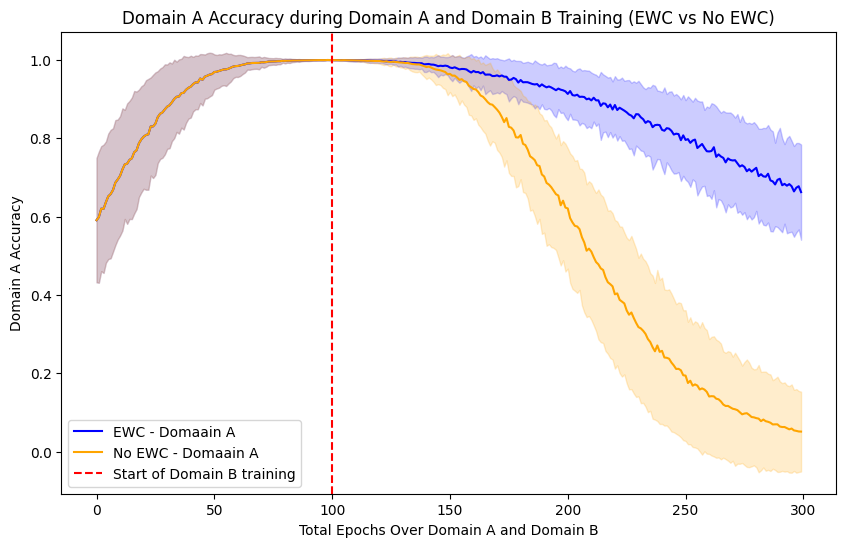

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate the mean and standard deviation for Task A during Task A and Task B across all runs
ewc_initial_acc_mean = np.mean(epoch_stats["ewc"]["A_during_A_val"], axis=0)  # Mean across runs for EWC
ewc_initial_acc_std = np.std(epoch_stats["ewc"]["A_during_A_val"], axis=0)    # Standard deviation for EWC

no_ewc_initial_acc_mean = np.mean(epoch_stats["ewc"]["A_during_A_val"], axis=0)  # Mean for No EWC
no_ewc_initial_acc_std = np.std(epoch_stats["ewc"]["A_during_A_val"], axis=0)    # Standard deviation for No EWC

# Calculate the mean and standard deviation for Task A during Task B training
ewc_task_A_during_B_mean = np.mean(epoch_stats["ewc"]["task_A_during_B"], axis=0)  # Mean over runs for EWC

ewc_task_A_during_B_std = np.std(epoch_stats["ewc"]["task_A_during_B"], axis=0)    # Standard deviation for EWC

no_ewc_task_A_during_B_mean = np.mean(epoch_stats["no_ewc"]["task_A_during_B"], axis=0)  # Mean for No EWC
no_ewc_task_A_during_B_std = np.std(epoch_stats["no_ewc"]["task_A_during_B"], axis=0)    # Standard deviation for No EWC

# Concatenate the mean values for Task A accuracy during Task A and Task B phases
ewc_task_A_combined_mean = np.concatenate([ewc_initial_acc_mean, ewc_task_A_during_B_mean])
no_ewc_task_A_combined_mean = np.concatenate([no_ewc_initial_acc_mean, no_ewc_task_A_during_B_mean])

# Concatenate the standard deviations for Task A accuracy during Task A and Task B phases
ewc_task_A_combined_std = np.concatenate([ewc_initial_acc_std, ewc_task_A_during_B_std])
no_ewc_task_A_combined_std = np.concatenate([no_ewc_initial_acc_std, no_ewc_task_A_during_B_std])

# X-axis: first half for Task A training, second half for Task B training
total_epochs = len(ewc_task_A_combined_mean)
x_values = np.arange(total_epochs)

# Plotting
plt.figure(figsize=(10, 6))

# Plot EWC mean with standard deviation shading
plt.plot(x_values, ewc_task_A_combined_mean, label='EWC - Domaain A', color='blue')
plt.fill_between(x_values, ewc_task_A_combined_mean - ewc_task_A_combined_std,
                 ewc_task_A_combined_mean + ewc_task_A_combined_std, color='blue', alpha=0.2)

# Plot No EWC mean with standard deviation shading
plt.plot(x_values, no_ewc_task_A_combined_mean, label='No EWC - Domaain A', color='orange')
plt.fill_between(x_values, no_ewc_task_A_combined_mean - no_ewc_task_A_combined_std,
                 no_ewc_task_A_combined_mean + no_ewc_task_A_combined_std, color='orange', alpha=0.2)

# Mark the point where Task B training begins
plt.axvline(x=len(ewc_initial_acc_mean), color='red', linestyle='--', label='Start of Domain B training')

# Labels, title, and legend
plt.xlabel('Total Epochs Over Domain A and Domain B')
plt.ylabel('Domain A Accuracy')
plt.title('Domain A Accuracy during Domain A and Domain B Training (EWC vs No EWC)')
plt.legend()

# Save and show the plot
#plt.savefig('dil_bench_accuracy_taskA_variance.png')
plt.show()


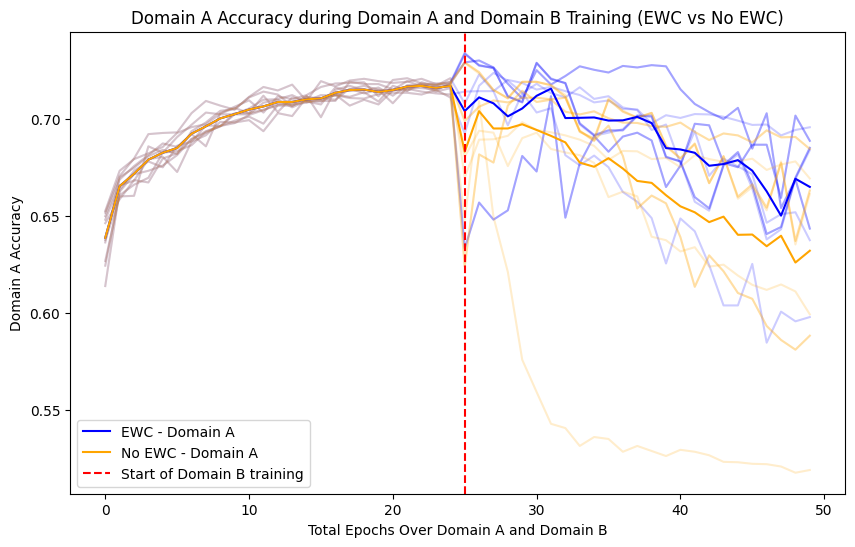

In [124]:
import numpy as np
import matplotlib.pyplot as plt

# X-axis: first half for Domain A training, second half for Domain B training
total_epochs = len(np.concatenate([epoch_stats_A["Initial"]["accuracy"][0], combined_ewc["ewc"]["task_A_during_B"][0]]))
x_values = np.arange(total_epochs)

# Plotting
plt.figure(figsize=(10, 6))

# Plot all individual runs for EWC
for run_initial, run_during_B in zip(epoch_stats_A["Initial"]["accuracy"], combined_ewc["ewc"]["task_A_during_B"]):
    ewc_task_A_combined_run = np.concatenate([run_initial, run_during_B])
    plt.plot(x_values, ewc_task_A_combined_run, color='blue', alpha=0.2)  # Plot faded lines for individual runs

# Plot all individual runs for No EWC
for run_initial, run_during_B in zip(epoch_stats_A["Initial"]["accuracy"], combined_ewc["no_ewc"]["task_A_during_B"]):
    no_ewc_task_A_combined_run = np.concatenate([run_initial, run_during_B])
    plt.plot(x_values, no_ewc_task_A_combined_run, color='orange', alpha=0.2)  # Plot faded lines for individual runs

# Calculate the mean for Task A during Task A and Task B training
ewc_task_A_combined_mean = np.concatenate([np.mean(epoch_stats_A["Initial"]["accuracy"], axis=0), np.mean(combined_ewc["ewc"]["task_A_during_B"], axis=0)])
no_ewc_task_A_combined_mean = np.concatenate([np.mean(epoch_stats_A["Initial"]["accuracy"], axis=0), np.mean(combined_ewc["no_ewc"]["task_A_during_B"], axis=0)])

# Plot EWC mean in solid color
plt.plot(x_values, ewc_task_A_combined_mean, label='EWC - Domain A', color='blue')

# Plot No EWC mean in solid color
plt.plot(x_values, no_ewc_task_A_combined_mean, label='No EWC - Domain A', color='orange')

# Mark the point where Task B training begins
plt.axvline(x=len(epoch_stats_A["Initial"]["accuracy"][0]), color='red', linestyle='--', label='Start of Domain B training')

# Labels, title, and legend
plt.xlabel('Total Epochs Over Domain A and Domain B')
plt.ylabel('Domain A Accuracy')
plt.title('Domain A Accuracy during Domain A and Domain B Training (EWC vs No EWC)')
plt.legend()

# Save and show the plot
plt.savefig('dil_bench_accuracy_taskA_individual_runs.png')
plt.show()


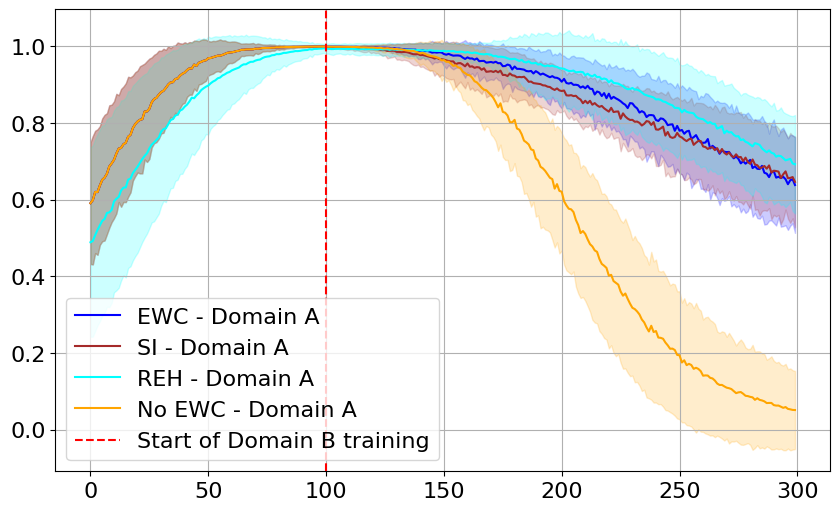

In [68]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate the mean and standard deviation for Task A during Task A and Task B across all runs
ewc_initial_acc_mean = np.mean(epoch_stats["ewc"]["A_during_A_val"], axis=0)  # Mean across runs for EWC
ewc_initial_acc_std = np.std(epoch_stats["ewc"]["A_during_A_val"], axis=0)    # Standard deviation for EWC

no_ewc_initial_acc_mean = np.mean(epoch_stats["ewc"]["A_during_A_val"], axis=0)  # Mean for No EWC
no_ewc_initial_acc_std = np.std(epoch_stats["ewc"]["A_during_A_val"], axis=0)    # Standard deviation for No EWC

si_initial_acc_mean = np.mean(epoch_stats_other_reh_buffer_2000["si"]["A_during_A_val"], axis=0)  # Mean for No EWC
si_initial_acc_std = np.std(epoch_stats_other_reh_buffer_2000["si"]["A_during_A_val"], axis=0)

reh_initial_acc_mean = np.mean(epoch_stats_other_reh_buffer_2000["reh"]["A_during_A_val"], axis=0)  # Mean for No EWC
reh_initial_acc_std = np.std(epoch_stats_other_reh_buffer_2000["reh"]["A_during_A_val"], axis=0)


# Calculate the mean and standard deviation for Task A during Task B training
ewc_task_A_during_B_mean = np.mean(epoch_stats["ewc"]["val_task_A_during_B"], axis=0)  # Mean over runs for EWC
ewc_task_A_during_B_std = np.std(epoch_stats["ewc"]["val_task_A_during_B"], axis=0)    # Standard deviation for EWC

si_task_A_during_B_mean = np.mean(epoch_stats_other_reh_buffer_2000["si"]["val_domain_A_during_B"], axis=0)  # Mean over runs for EWC
si_task_A_during_B_std = np.std(epoch_stats_other_reh_buffer_2000["si"]["val_domain_A_during_B"], axis=0)    # Standard deviation for EWC

reh_task_A_during_B_mean = np.mean(epoch_stats_other_reh_buffer_2000["reh"]["val_domain_A_during_B"], axis=0)  # Mean over runs for EWC
reh_task_A_during_B_std = np.std(epoch_stats_other_reh_buffer_2000["reh"]["val_domain_A_during_B"], axis=0)    # Standard deviation for EWC

# no_ewc_task_A_during_B_mean = np.mean(combined_ewc["no_ewc"]["task_A_during_B"], axis=0)  # Mean for No EWC
# no_ewc_task_A_during_B_std = np.std(combined_ewc["no_ewc"]["task_A_during_B"], axis=0)    # Standard deviation for No EWC

# Concatenate the mean values for Task A accuracy during Task A and Task B phases
ewc_task_A_combined_mean = np.concatenate([ewc_initial_acc_mean, ewc_task_A_during_B_mean])
no_ewc_task_A_combined_mean = np.concatenate([no_ewc_initial_acc_mean, no_ewc_task_A_during_B_mean])


si_task_A_combined_mean = np.concatenate([ewc_initial_acc_mean, si_task_A_during_B_mean])
reh_task_A_combined_mean = np.concatenate([reh_initial_acc_mean, reh_task_A_during_B_mean])

# Concatenate the standard deviations for Task A accuracy during Task A and Task B phases
ewc_task_A_combined_std = np.concatenate([ewc_initial_acc_std, ewc_task_A_during_B_std])
no_ewc_task_A_combined_std = np.concatenate([no_ewc_initial_acc_std, no_ewc_task_A_during_B_std])


si_task_A_combined_std = np.concatenate([ewc_initial_acc_std, si_task_A_during_B_std])
reh_task_A_combined_std = np.concatenate([reh_initial_acc_std, reh_task_A_during_B_std])

# X-axis: first half for Task A training, second half for Task B training
total_epochs = len(ewc_task_A_combined_mean)
x_values = np.arange(total_epochs)

# Plotting
plt.figure(figsize=(10, 6))

# Plot EWC mean with standard deviation shading
plt.plot(x_values, ewc_task_A_combined_mean, label='EWC - Domain A', color='blue')
plt.fill_between(x_values, ewc_task_A_combined_mean - ewc_task_A_combined_std,
                 ewc_task_A_combined_mean + ewc_task_A_combined_std, color='blue', alpha=0.2)

# Plot SI mean with standard deviation shading
plt.plot(x_values, si_task_A_combined_mean, label='SI - Domain A', color='brown')
plt.fill_between(x_values, si_task_A_combined_mean - si_task_A_combined_std,
                 si_task_A_combined_mean + si_task_A_combined_std, color='brown', alpha=0.2)

# Plot REH mean with standard deviation shading
plt.plot(x_values, reh_task_A_combined_mean, label='REH - Domain A', color='cyan')
plt.fill_between(x_values, reh_task_A_combined_mean - reh_task_A_combined_std,
                 reh_task_A_combined_mean + reh_task_A_combined_std, color='cyan', alpha=0.2)

# Plot No EWC mean with standard deviation shading
plt.plot(x_values, no_ewc_task_A_combined_mean, label='No EWC - Domain A', color='orange')
plt.fill_between(x_values, no_ewc_task_A_combined_mean - no_ewc_task_A_combined_std,
                 no_ewc_task_A_combined_mean + no_ewc_task_A_combined_std, color='orange', alpha=0.2)

# Mark the point where Task B training begins
plt.axvline(x=len(ewc_initial_acc_mean), color='red', linestyle='--', label='Start of Domain B training')

# Labels, title, and legend
plt.xticks(fontsize=16)                 # Font size for x-axis ticks
plt.yticks(fontsize=16) 
plt.legend(fontsize=16)
plt.grid(True)

# Save and show the plot
plt.savefig('dil_bench_accuracy_taskA_all_methods_variance_bigger.png')
plt.show()


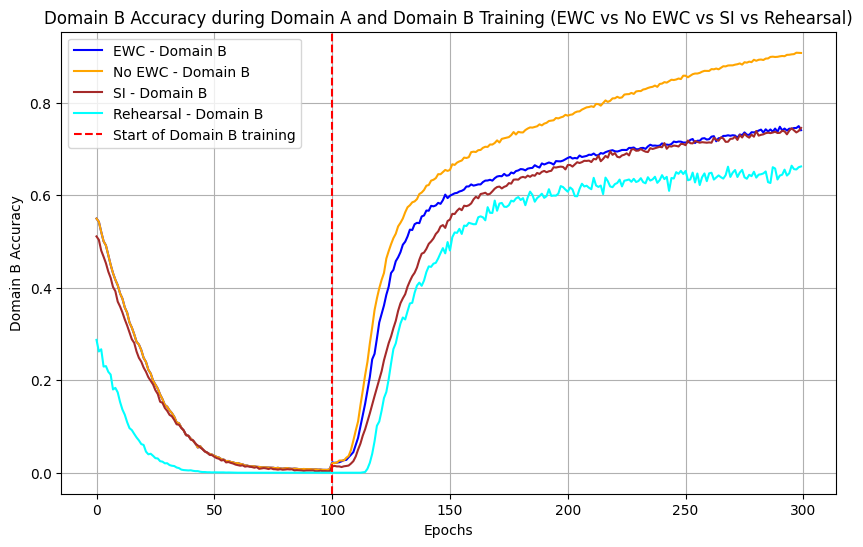

In [52]:
import numpy as np
import matplotlib.pyplot as plt

# Compute the mean across runs for each method
task_B_ewc = np.mean(epoch_stats["ewc"]["val_task_B"], axis=0)  # Mean across runs for EWC
task_B_no_ewc = np.mean(epoch_stats["no_ewc"]["val_task_B"], axis=0)  # Mean across runs for No EWC
task_B_si = np.mean(epoch_stats_other["si"]["val_acc_B"], axis=0)  # Mean across runs for SI
task_B_reh = np.mean(epoch_stats_other["reh"]["val_acc_B"], axis=0)  # Mean across runs for Rehearsal
#task_B_pnn = np.mean(epoch_stats_other["pnn"]["val_acc_B"], axis=0)  # Mean across runs for PNN

# Compute the mean across runs for each method on Domain B during training on Domain A
task_B_during_A_ewc = np.mean(epoch_stats["ewc"]["B_during_A_val"], axis=0)
task_B_during_A_no_ewc = np.mean(epoch_stats["ewc"]["B_during_A_val"], axis=0)
task_B_during_A_si = np.mean(epoch_stats_other["si"]["B_during_A_val"], axis=0)
task_B_during_A_reh = np.mean(epoch_stats_other["reh"]["B_during_A_val"], axis=0)
#task_B_during_A_pnn = np.mean(epoch_stats_other["pnn"]["B_during_A_val"], axis=0)

# Concatenate Task B accuracy for both phases: during Task A and during Task B training
ewc_task_B_combined = np.concatenate([task_B_during_A_ewc, task_B_ewc])
no_ewc_task_B_combined = np.concatenate([task_B_during_A_no_ewc, task_B_no_ewc])
#pnn_task_B_combined = np.concatenate([task_B_during_A_pnn, task_B_pnn])
si_task_B_combined = np.concatenate([task_B_during_A_si, task_B_si])
reh_task_B_combined = np.concatenate([task_B_during_A_reh, task_B_reh])

# Define x-axis for the entire epoch range across both phases
total_epochs = len(ewc_task_B_combined)
x_values = np.arange(total_epochs)

# Plot the results
plt.figure(figsize=(10, 6))

# Plot MAE for each method
# Plot Domain B accuracy during training on Domain B for each method
plt.plot(x_values, ewc_task_B_combined, label='EWC - Domain B', color='blue')
plt.plot(x_values, no_ewc_task_B_combined, label='No EWC - Domain B', color='orange')
#plt.plot(x_values, pnn_task_B_combined, label='PNN - Domain B', color='green')
plt.plot(x_values, si_task_B_combined, label='SI - Domain B', color='brown')
plt.plot(x_values, reh_task_B_combined, label='Rehearsal - Domain B', color='cyan')

# Mark the point where Task B training begins
plt.axvline(x=len(task_B_during_A_ewc), color='red', linestyle='--', label='Start of Domain B training')

# Labels, title, and legend
plt.xlabel('Epochs')
plt.ylabel('Domain B Accuracy')
plt.title('Domain B Accuracy during Domain A and Domain B Training (EWC vs No EWC vs SI vs Rehearsal)')
plt.legend()
plt.grid(True)

# Show the plot
#plt.savefig('dil_bench_accuracy_domainB.png')
plt.show()


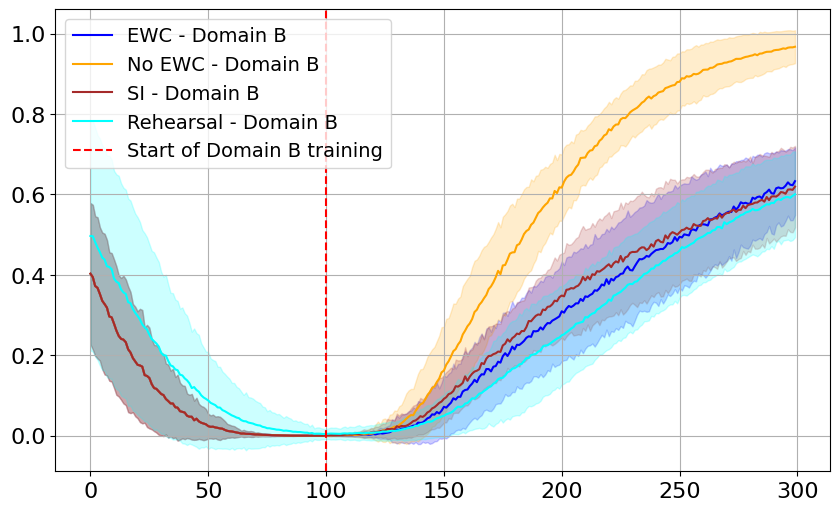

In [69]:
import numpy as np
import matplotlib.pyplot as plt

# Compute the mean across runs for each method
task_B_ewc = np.mean(epoch_stats["ewc"]["val_task_B"], axis=0)
task_B_no_ewc = np.mean(epoch_stats["no_ewc"]["val_task_B"], axis=0)
task_B_si = np.mean(epoch_stats_other_reh_buffer_2000["si"]["val_acc_B"], axis=0)
task_B_reh = np.mean(epoch_stats_other_reh_buffer_2000["reh"]["val_acc_B"], axis=0)

# Compute the standard deviation for variance bands
task_B_ewc_std = np.std(epoch_stats["ewc"]["val_task_B"], axis=0)
task_B_no_ewc_std = np.std(epoch_stats["no_ewc"]["val_task_B"], axis=0)
task_B_si_std = np.std(epoch_stats_other_reh_buffer_2000["si"]["val_acc_B"], axis=0)
task_B_reh_std = np.std(epoch_stats_other_reh_buffer_2000["reh"]["val_acc_B"], axis=0)

# Compute the mean and standard deviation during Domain A training
task_B_during_A_ewc = np.mean(epoch_stats["ewc"]["B_during_A_val"], axis=0)
task_B_during_A_no_ewc = np.mean(epoch_stats["ewc"]["B_during_A_val"], axis=0)
task_B_during_A_si = np.mean(epoch_stats_other_reh_buffer_2000["si"]["B_during_A_val"], axis=0)
task_B_during_A_reh = np.mean(epoch_stats_other_reh_buffer_2000["reh"]["B_during_A_val"], axis=0)

task_B_during_A_ewc_std = np.std(epoch_stats["ewc"]["B_during_A_val"], axis=0)
task_B_during_A_no_ewc_std = np.std(epoch_stats["ewc"]["B_during_A_val"], axis=0)
task_B_during_A_si_std = np.std(epoch_stats_other_reh_buffer_2000["si"]["B_during_A_val"], axis=0)
task_B_during_A_reh_std = np.std(epoch_stats_other_reh_buffer_2000["reh"]["B_during_A_val"], axis=0)

# Concatenate Task B accuracy for both phases: during Task A and during Task B training
ewc_task_B_combined = np.concatenate([task_B_during_A_ewc, task_B_ewc])
no_ewc_task_B_combined = np.concatenate([task_B_during_A_no_ewc, task_B_no_ewc])
si_task_B_combined = np.concatenate([task_B_during_A_ewc, task_B_si])
reh_task_B_combined = np.concatenate([task_B_during_A_reh, task_B_reh])

ewc_task_B_combined_std = np.concatenate([task_B_during_A_ewc_std, task_B_ewc_std])
no_ewc_task_B_combined_std = np.concatenate([task_B_during_A_no_ewc_std, task_B_no_ewc_std])
si_task_B_combined_std = np.concatenate([task_B_during_A_no_ewc_std, task_B_si_std])
reh_task_B_combined_std = np.concatenate([task_B_during_A_reh_std, task_B_reh_std])

# Define x-axis for the entire epoch range across both phases
total_epochs = len(ewc_task_B_combined)
x_values = np.arange(total_epochs)

# Plot the results with variance bands
plt.figure(figsize=(10, 6))

# Plot EWC with variance band
plt.plot(x_values, ewc_task_B_combined, label='EWC - Domain B', color='blue')
plt.fill_between(x_values, ewc_task_B_combined - ewc_task_B_combined_std, ewc_task_B_combined + ewc_task_B_combined_std, color='blue', alpha=0.2)

# Plot No EWC with variance band
plt.plot(x_values, no_ewc_task_B_combined, label='No EWC - Domain B', color='orange')
plt.fill_between(x_values, no_ewc_task_B_combined - no_ewc_task_B_combined_std, no_ewc_task_B_combined + no_ewc_task_B_combined_std, color='orange', alpha=0.2)

# Plot SI with variance band
plt.plot(x_values, si_task_B_combined, label='SI - Domain B', color='brown')
plt.fill_between(x_values, si_task_B_combined - si_task_B_combined_std, si_task_B_combined + si_task_B_combined_std, color='brown', alpha=0.2)

# Plot Rehearsal with variance band
plt.plot(x_values, reh_task_B_combined, label='Rehearsal - Domain B', color='cyan')
plt.fill_between(x_values, reh_task_B_combined - reh_task_B_combined_std, reh_task_B_combined + reh_task_B_combined_std, color='cyan', alpha=0.2)

# Mark the point where Task B training begins
plt.axvline(x=len(task_B_during_A_ewc), color='red', linestyle='--', label='Start of Domain B training')

# Labels, title, and legend
plt.xticks(fontsize=16)                 # Font size for x-axis ticks
plt.yticks(fontsize=16) 
plt.legend(loc='upper left',fontsize=14)
plt.grid(True)

# Save and show the plot
plt.savefig('dil_bench_accuracy_domainB_with_variance_bigger.png')
plt.show()


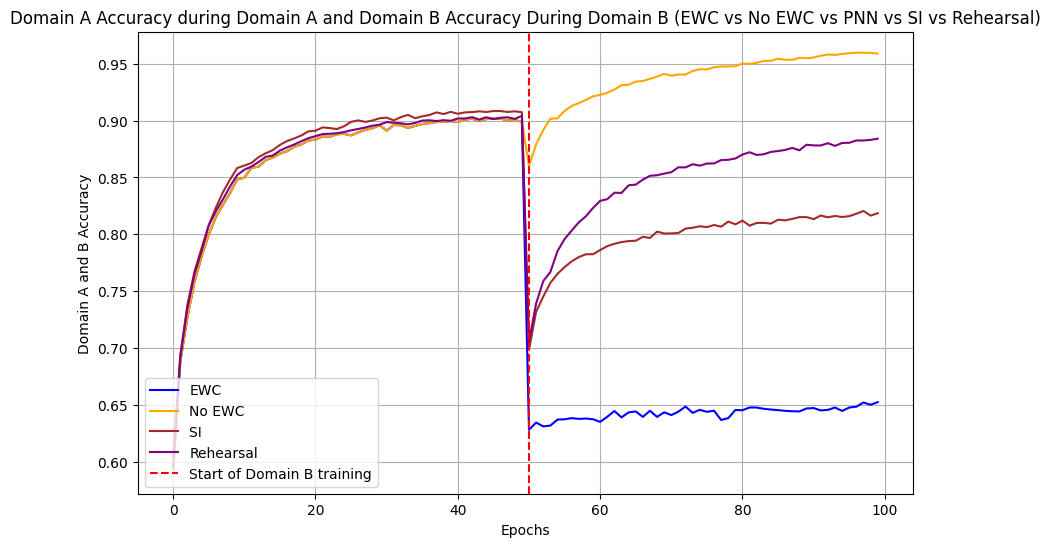

In [100]:
import numpy as np
import matplotlib.pyplot as plt

# Concatenate Task B accuracy for both phases: during Task A and during Task B training
ewc_task_A_and_B_combined = np.concatenate([ewc_initial_acc, task_B_ewc])
no_ewc_task_A_and_B_combined = np.concatenate([no_ewc_initial_acc, task_B_no_ewc])
#pnn_task_A_and_B_combined = np.concatenate([pnn_initial_acc, task_B_pnn])
si_task_A_and_B_combined = np.concatenate([si_initial_acc, task_B_si])
reh_task_A_and_B_combined = np.concatenate([reh_initial_acc, task_B_reh])

# Define x-axis for the entire epoch range across both phases
total_epochs = len(ewc_task_B_combined)
x_values = np.arange(total_epochs)

# Plot the results
plt.figure(figsize=(10, 6))

# Plot MAE for each method
# Plot Domain B accuracy during training on Domain B for each method
plt.plot(x_values, ewc_task_A_and_B_combined, label='EWC', color='blue')
plt.plot(x_values, no_ewc_task_A_and_B_combined, label='No EWC', color='orange')
#plt.plot(x_values, pnn_task_A_and_B_combined, label='PNN', color='green')
plt.plot(x_values, si_task_A_and_B_combined, label='SI ', color='brown')
plt.plot(x_values, reh_task_A_and_B_combined, label='Rehearsal', color='purple')

# Mark the point where Task B training begins
plt.axvline(x=len(task_B_ewc), color='red', linestyle='--', label='Start of Domain B training')

# Labels, title, and legend
plt.xlabel('Epochs')
plt.ylabel('Domain A and B Accuracy')
plt.title('Domain A Accuracy during Domain A and Domain B Accuracy During Domain B (EWC vs No EWC vs PNN vs SI vs Rehearsal)')
plt.legend()
plt.grid(True)

# Show the plot
plt.savefig('dil_bench_accuracy_domainA_duringA_and_domB_during_B.png')
plt.show()


In [65]:
# Extract data directly from dictionaries without modifying their original structure
import pandas as pd
# Helper function to calculate max, min, and mean for final epoch from a dictionary
def calculate_final_epoch_stats_from_dict(data_dict, key):
    data = np.array(data_dict[key])  # Convert to NumPy array
    max_final = np.max(data[:, -1])  # Max of the final epoch
    min_final = np.min(data[:, -1])  # Min of the final epoch
    mean_final = np.mean(data[:, -1])  # Mean of the final epoch
    return max_final, min_final, mean_final

# Function to calculate final epoch statistics including upper and lower bounds
def calculate_final_epoch_stats_with_bounds(data_dict, key):
    data = np.array(data_dict[key])  # Convert to NumPy array
    mean_final = np.mean(data[:, -1])  # Mean of the final epoch
    std_final = np.std(data[:, -1])  # Standard deviation of the final epoch
    max_final = np.max(data[:, -1])  # Max of the final epoch
    min_final = np.min(data[:, -1])  # Min of the final epoch
    upper_bound = mean_final + 2 * std_final  # Mean + 2 Standard Deviations
    lower_bound = mean_final - 2 * std_final  # Mean - 2 Standard Deviations
    return max_final, min_final, mean_final, upper_bound, lower_bound

# Average of the final epoch for Task A during Task A training
avg_final_epoch_task_A_A = np.mean(np.array(epoch_stats["ewc"]["A_during_A_val"])[:, -1])
avg_final_epoch_task_A_A_si = np.mean(np.array(epoch_stats_other_reh_buffer_2000["si"]["A_during_A_val"])[:, -1])
avg_final_epoch_task_A_A_reh = np.mean(np.array(epoch_stats_other_reh_buffer_2000["reh"]["A_during_A_val"])[:, -1])

# Extract final epoch statistics for Task A during Task B training
ewc_max_final, ewc_min_final, ewc_mean_final, ewc_upper_bound, ewc_lower_bound = calculate_final_epoch_stats_with_bounds(epoch_stats["ewc"], "val_task_A_during_B")
no_ewc_max_final, no_ewc_min_final, no_ewc_mean_final, no_ewc_upper_bound, no_ewc_lower_bound = calculate_final_epoch_stats_with_bounds(epoch_stats["no_ewc"], "val_task_A_during_B")
si_max_final, si_min_final, si_mean_final, si_upper_bound, si_lower_bound = calculate_final_epoch_stats_with_bounds(epoch_stats_other_reh_buffer_2000["si"], "val_domain_A_during_B")
reh_max_final, reh_min_final, reh_mean_final, reh_upper_bound, reh_lower_bound = calculate_final_epoch_stats_with_bounds(epoch_stats_other_reh_buffer_2000["reh"], "val_domain_A_during_B")

# Create a summary table for Task A during Task B training
final_epoch_summary = pd.DataFrame({
    "Method": ["EWC", "No EWC", "SI", "Rehearsal"],
    "Domain A After A": [avg_final_epoch_task_A_A, avg_final_epoch_task_A_A, avg_final_epoch_task_A_A_si, avg_final_epoch_task_A_A_reh],
    "Max Acc After B": [ewc_max_final, no_ewc_max_final, si_max_final, reh_max_final],
    "Min Acc After B": [ewc_min_final, no_ewc_min_final, si_min_final, reh_min_final],
    "Mean Acc After B": [ewc_mean_final, no_ewc_mean_final, si_mean_final, reh_mean_final],
    "Upper Bound": [ewc_upper_bound, no_ewc_upper_bound, si_upper_bound, reh_upper_bound],
    "Lower Bound": [ewc_lower_bound, no_ewc_lower_bound, si_lower_bound, reh_lower_bound]
})




# Display results
# Display results using print for both tables


print("\Domain A Performance After Training on Domain A and After Domain B")
print(final_epoch_summary)





\Domain A Performance After Training on Domain A and After Domain B
      Method  Domain A After A  Max Acc After B  Min Acc After B  \
0        EWC          0.999644         0.789795         0.445160   
1     No EWC          0.999644         0.340736         0.000000   
2         SI          0.999271         0.841499         0.455501   
3  Rehearsal          0.994971         0.890659         0.256993   

   Mean Acc After B  Upper Bound  Lower Bound  
0          0.638278     0.888169     0.388386  
1          0.049347     0.249107    -0.150413  
2          0.646449     0.883386     0.409511  
3          0.692426     0.949520     0.435331  


In [70]:
# Calculate statistics for the final epoch of Task B during Task B training

# Helper function to calculate mean, max, min, and std deviation for the final epoch
def calculate_final_epoch_stats_task_B(data_dict, key):
    data = np.array(data_dict[key])  # Convert to NumPy array
    mean_final = np.mean(data[:, -1])  # Mean of the final epoch
    max_final = np.max(data[:, -1])  # Max of the final epoch
    min_final = np.min(data[:, -1])  # Min of the final epoch
    std_final = np.std(data[:, -1])  # Standard deviation of the final epoch
    upper_bound = mean_final + 2 * std_final  # Upper bound (mean + 2SD)
    lower_bound = mean_final - 2 * std_final  # Lower bound (mean - 2SD)
    return mean_final, max_final, min_final, upper_bound, lower_bound

# Calculate stats for each method
task_B_ewc_mean, task_B_ewc_max, task_B_ewc_min, task_B_ewc_upper, task_B_ewc_lower = calculate_final_epoch_stats_task_B(epoch_stats["ewc"], "val_task_B")
task_B_no_ewc_mean, task_B_no_ewc_max, task_B_no_ewc_min, task_B_no_ewc_upper, task_B_no_ewc_lower = calculate_final_epoch_stats_task_B(epoch_stats["no_ewc"], "val_task_B")
task_B_si_mean, task_B_si_max, task_B_si_min, task_B_si_upper, task_B_si_lower = calculate_final_epoch_stats_task_B(epoch_stats_other_reh_buffer_2000["si"], "val_acc_B")
task_B_reh_mean, task_B_reh_max, task_B_reh_min, task_B_reh_upper, task_B_reh_lower = calculate_final_epoch_stats_task_B(epoch_stats_other_reh_buffer_2000["reh"], "val_acc_B")

# Create a summary table for Task B during Task B training including upper and lower bounds
final_epoch_task_B_summary = pd.DataFrame({
    "Method": ["EWC", "No EWC", "SI", "Rehearsal"],
    "Mean Final Acc": [task_B_ewc_mean, task_B_no_ewc_mean, task_B_si_mean, task_B_reh_mean],
    "Max Final Acc": [task_B_ewc_max, task_B_no_ewc_max, task_B_si_max, task_B_reh_max],
    "Min Final Acc": [task_B_ewc_min, task_B_no_ewc_min, task_B_si_min, task_B_reh_min],
    "Upper Bound (Mean + 2SD)": [task_B_ewc_upper, task_B_no_ewc_upper, task_B_si_upper, task_B_reh_upper],
    "Lower Bound (Mean - 2SD)": [task_B_ewc_lower, task_B_no_ewc_lower, task_B_si_lower, task_B_reh_lower]
})



# Display results for Task B
print("Performance for Domain B After Domain B Training")
print(final_epoch_task_B_summary)


Performance for Domain B After Domain B Training
      Method  Mean Final Acc  Max Final Acc  Min Final Acc  \
0        EWC        0.632956       0.749754       0.518027   
1     No EWC        0.967224       1.000000       0.882170   
2         SI        0.619453       0.743691       0.458047   
3  Rehearsal        0.600412       0.879056       0.364962   

   Upper Bound (Mean + 2SD)  Lower Bound (Mean - 2SD)  
0                  0.801325                  0.464588  
1                  1.049144                  0.885303  
2                  0.822182                  0.416723  
3                  0.813832                  0.386992  


In [21]:
def train_with_l2(model, optimizer, dataloaders, criterion, lambda_l2, epochs=1):
    """Train model using L2 regularization (weight decay)."""
    model.train()
    for epoch in range(epochs):
        total_loss = 0.0
        for data, target in dataloaders['train']:
            data = data.float()  # Ensure data is float32
            target = target.float().view(-1, 1)  # Fix shape issue

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)  # BCE Loss
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(dataloaders['train']):.4f}")


In [59]:
# Calculate the mean and standard deviation for Task A during Task A and Task B across all runs
l2_initial_acc_mean = np.mean(epoch_stats_l2["l2"]["A_during_A"], axis=0)  # Mean across runs for L2
l2_initial_acc_std = np.std(epoch_stats_l2["l2"]["A_during_A"], axis=0)    # Standard deviation for L2

# Calculate the mean and standard deviation for Task A during Task B training
l2_task_A_during_B_mean = np.mean(epoch_stats_l2["l2"]["A_during_B"], axis=0)  # Mean over runs for L2
l2_task_A_during_B_std = np.std(epoch_stats_l2["l2"]["A_during_B"], axis=0)    # Standard deviation for L2

# Concatenate the mean values for Task A accuracy during Task A and Task B phases
l2_task_A_combined_mean = np.concatenate([l2_initial_acc_mean, l2_task_A_during_B_mean])

# Concatenate the standard deviations for Task A accuracy during Task A and Task B phases
l2_task_A_combined_std = np.concatenate([l2_initial_acc_std, l2_task_A_during_B_std])
